In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold_slicing
import omnifold_routine
import PET
sys.path.append('.')
from my_utils import *

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="0" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2026-01-13 09:28:09.631997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 09:28:10.252991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768292890.447580  944242 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768292890.495221  944242 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768292891.016304  944242 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

#pythia_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_pythia_ttbar_singletop_DR.pkl')
#pythia_ttbar_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
Sig_bckg_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/WbWb_background_df.pkl')
pythia_background = Sig_bckg_df
#pythia_ttbar_df = Sig_bckg_df[:192570169]
pythia_df = Sig_bckg_df[:195191120]
data_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_data.pkl')
data_df.fillna(0.0, inplace=True)

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1 / luminosity)


In [4]:
pythia_train, pythia_test = subset(Sig_bckg_df[Sig_bckg_df["pass_matched"]==1], 5_000_000, train_test=True)
pythia_unmatched = pythia_df
pythia_matched = pythia_df[pythia_df["pass_matched"]==1]

#data_subset = subset(data_df, 4_300_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
data_array = DATA_shaper(data_df)
pythia_reco_unmatched, pythia_truth_unmatched = MC_data_shaper(pythia_unmatched)
pythia_reco_matched, pythia_truth_matched = MC_data_shaper(pythia_matched)
#pythia_reco_ttbar, pythia_truth_ttbar = MC_data_shaper(pythia_ttbar_df)
#pythia_reco_background, pythia_truth_background = MC_data_shaper(pythia_background)

In [87]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = 1 / luminosity
hist = TUnfold_incl_file[f'unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()
matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched['eventWeight'] * SF
    )
unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched['eventWeight'] * SF
    )

reco_matched_hist, _ = np.histogram(
    pythia_reco_matched[:, 0, 0],
    bins=edges,
    weights=pythia_matched['eventWeight'] * SF
)
reco_unmatched_hist, _ = np.histogram(
    pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0]!=0],
    bins=edges,
    weights=(pythia_unmatched['eventWeight'] * SF)[pythia_reco_unmatched[:, 0, 0]!=0]
)

# Efficiency
efficiency = np.zeros_like(unmatched_hist, dtype=float)
efficiency = matched_hist / unmatched_hist

# Acceptance
acceptance = np.zeros_like(reco_matched_hist, dtype=float)
acceptance = reco_matched_hist / reco_unmatched_hist

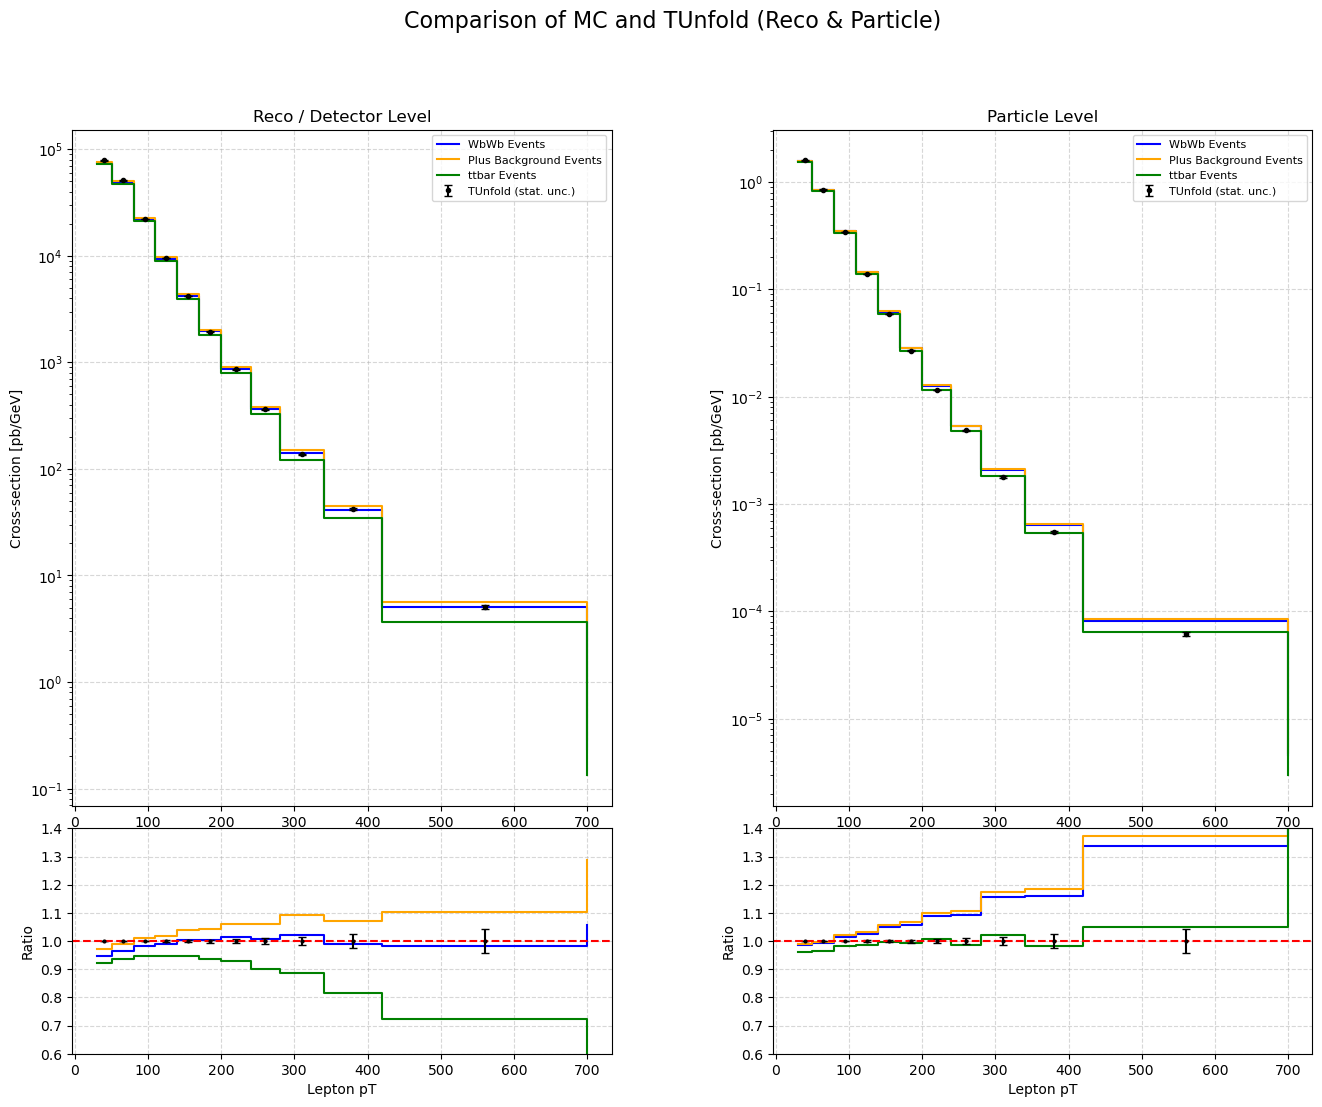

In [5]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = 1 / luminosity

obs_name = "ptl1"

# ------------------------------------------------------------
# Load particle-level TUnfold histogram
# ------------------------------------------------------------
hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
rel_pt_up = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1up;1']
rel_pt_down = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1down;1']

values = hist.values()
edges = hist.axis().edges()
bin_widths = np.diff(edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

values_density = values / bin_widths
rel_unc_up = rel_pt_up.values()
rel_unc_down = rel_pt_down.values()

# ------------------------------------------------------------
# Prepare figure: 2x2 panels (Reco / Particle, each with main + ratio)
# ------------------------------------------------------------
fig = plt.figure(figsize=(16, 12))
outer_gs = fig.add_gridspec(2, 2, width_ratios=[3,3], height_ratios=[3,1], wspace=0.3, hspace=0.05)

# Function to plot main + ratio
def plot_panel(ax_main, ax_ratio, mc_counts_list, mc_labels, data_density, rel_unc_up, rel_unc_down, edges, bin_centers):
    bin_widths = np.diff(edges)
    # Main panel
    colors = ['blue', 'orange', 'green']
    for counts, label, color in zip(mc_counts_list, mc_labels, colors):
        counts_density = counts / bin_widths
        ax_main.step(edges[:-1], counts_density, where='post', label=label, color=color)
    
    # Data points
    ax_main.errorbar(
        bin_centers[:-1], data_density[:-1],
        yerr=np.vstack((rel_unc_down * data_density, rel_unc_up * data_density))[:, :-1],
        fmt='o', color='black', capsize=3, markersize=3,
        label='TUnfold (stat. unc.)'
    )
    ax_main.set_yscale('log')
    ax_main.set_ylabel("Cross-section [pb/GeV]")
    ax_main.grid(True, ls='--', alpha=0.5)
    ax_main.legend(fontsize=8)
    
    # Ratio panel
    ratio_data = np.ones_like(data_density)
    yerr_data = np.vstack((ratio_data * rel_unc_down, ratio_data * rel_unc_up))
    
    colors_ratio = ['blue','orange','green']
    for counts, color in zip(mc_counts_list, colors_ratio):
        counts_density = counts / bin_widths
        ratio = np.divide(counts_density, data_density, out=np.zeros_like(counts_density), where=data_density!=0)
        ax_ratio.step(edges[:-1], ratio, where='post', color=color)
    
    ax_ratio.errorbar(
        bin_centers[:-1], ratio_data[:-1], yerr=yerr_data[:, :-1],
        fmt='o', color='black', capsize=3, markersize=2
    )
    ax_ratio.axhline(1.0, color='r', ls='--')
    ax_ratio.set_ylim(0.6, 1.4)
    ax_ratio.set_xlabel("Lepton pT")
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.grid(True, ls='--', alpha=0.5)

# ------------------------------------------------------------
# --- Reco / Detector Level ---
# ------------------------------------------------------------
ax_main_reco = fig.add_subplot(outer_gs[0,0])
ax_ratio_reco = fig.add_subplot(outer_gs[1,0], sharex=ax_main_reco)

# Compute MC histograms at reco level
counts_mc_all = np.histogram(
    pythia_reco_unmatched[:,0,0], bins=edges,
    weights=pythia_unmatched['eventWeight']*pythia_unmatched['pass_reco']
)[0]
counts_mc_background = np.histogram(
    pythia_reco_background[:,0,0], bins=edges,
    weights=pythia_background['eventWeight']*pythia_background['pass_reco']
)[0]
counts_mc_ttbar = np.histogram(
    pythia_reco_ttbar[:,0,0], bins=edges,
    weights=pythia_ttbar_df['eventWeight']*pythia_ttbar_df['pass_reco']
)[0]
counts_data_reco, _ = np.histogram(
    data_array[:,0,0], bins=edges,
    weights=data_df['eventWeight']
)
#counts_data_reco *= acceptance
mc_counts_list_reco = [counts_mc_all, counts_mc_background, counts_mc_ttbar]
mc_labels_reco = ["WbWb Events", "Plus Background Events", "ttbar Events"]

plot_panel(ax_main_reco, ax_ratio_reco, mc_counts_list_reco, mc_labels_reco, counts_data_reco / bin_widths, rel_unc_up, rel_unc_down, edges, bin_centers)
ax_main_reco.set_title("Reco / Detector Level")

# ------------------------------------------------------------
# --- Particle Level ---
# ------------------------------------------------------------
ax_main_part = fig.add_subplot(outer_gs[0,1])
ax_ratio_part = fig.add_subplot(outer_gs[1,1], sharex=ax_main_part)

# Compute MC histograms at particle level
counts_mc_all_part = np.histogram(
    pythia_truth_unmatched[:,0,0], bins=edges,
    weights=pythia_unmatched['eventWeight']*pythia_unmatched['pass_particle']*SF
)[0]
counts_mc_background_part = np.histogram(
    pythia_truth_background[:,0,0], bins=edges,
    weights=pythia_background['eventWeight']*pythia_background['pass_particle']*SF
)[0]
counts_mc_ttbar_part = np.histogram(
    pythia_truth_ttbar[:,0,0], bins=edges,
    weights=pythia_ttbar_df['eventWeight']*pythia_ttbar_df['pass_particle']*SF
)[0]

mc_counts_list_part = [counts_mc_all_part, counts_mc_background_part, counts_mc_ttbar_part]
mc_labels_part = ["WbWb Events", "Plus Background Events", "ttbar Events"]

plot_panel(ax_main_part, ax_ratio_part, mc_counts_list_part, mc_labels_part, values_density, rel_unc_up, rel_unc_down, edges, bin_centers)
ax_main_part.set_title("Particle Level")

fig.suptitle("Comparison of MC and TUnfold (Reco & Particle)", fontsize=16)
plt.show()


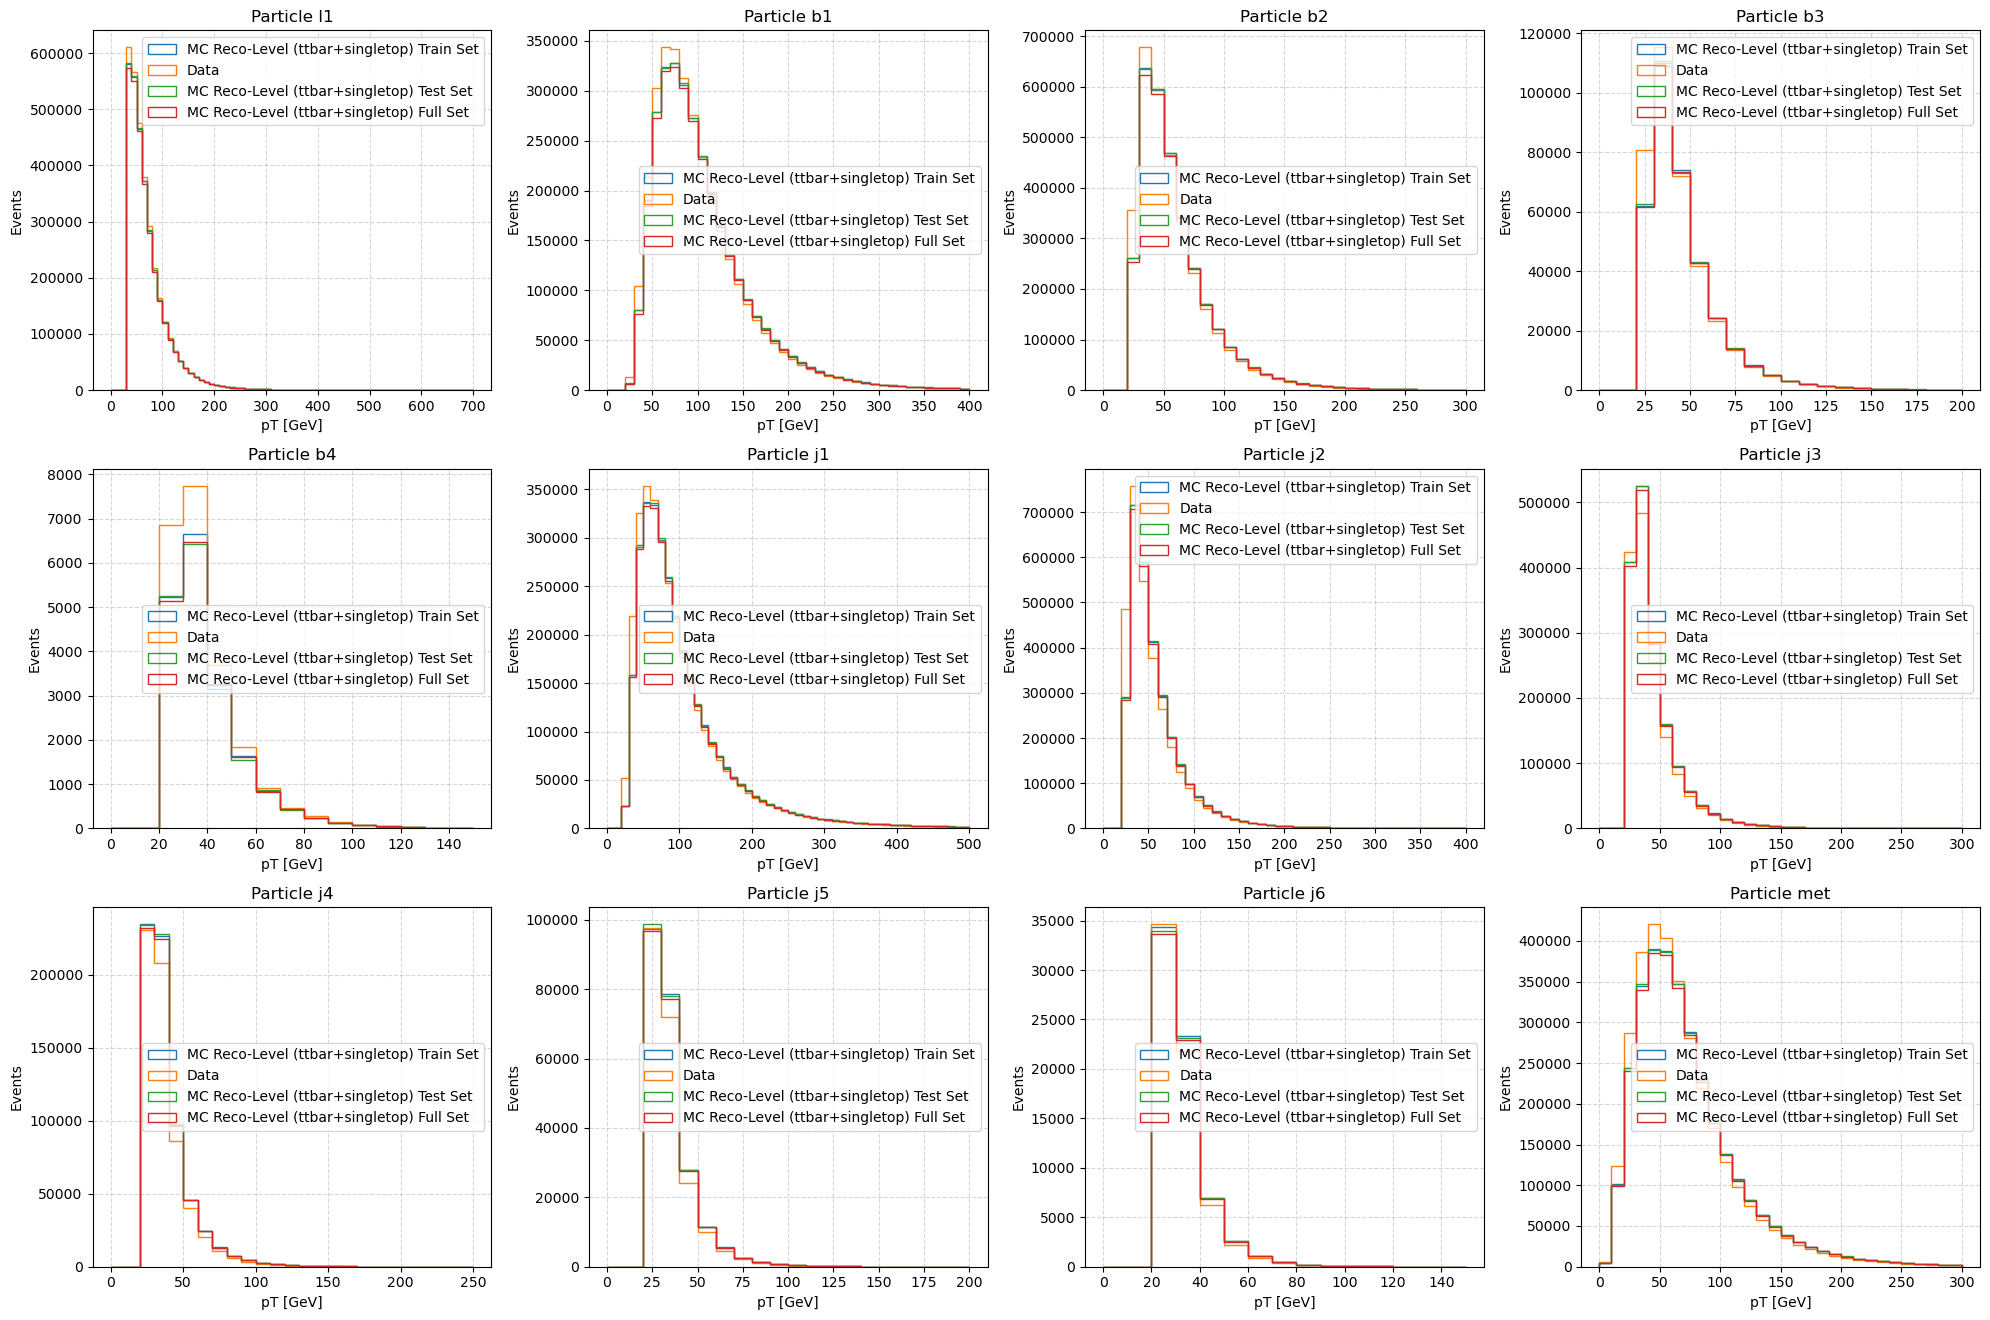

In [50]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_reco_train[:, i, 0] != 0
    mask_pythia_test = pythia_reco_test[:, i, 0] != 0
    mask_pythia_matched = pythia_reco_matched[:, i, 0] != 0
    mask_data = data_array[:,i,0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        (pythia_reco_train[:, i, 0])[mask_pythia],
        weights=(pythia_train['eventWeight'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar+singletop) Train Set'
    )
    ax.hist(
        data_array[:, i, 0][mask_data],
        weights = data_df['eventWeight'][mask_data]*0.75,
        bins=bins,
        histtype='step',
        label='Data'
    )
    ax.hist(
        (pythia_reco_test[:, i, 0])[mask_pythia_test],
        weights=(pythia_test['eventWeight'])[mask_pythia_test],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar+singletop) Test Set'
    )
    ax.hist(
        (pythia_reco_matched[:, i, 0])[mask_pythia_matched],
        weights=(pythia_matched['eventWeight'])[mask_pythia_matched],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar+singletop) Full Set'
    )

    
    ax.set_title(f"Particle {pname}")
    ax.legend()
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.grid(True, linestyle='--', alpha=0.5)
    


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [5]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_data_scaled = jet_scaler.transform(data_array)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

In [6]:
data_loader = DataLoader(reco = X_data_scaled, weight = data_df['eventWeight'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


In [65]:
data_loader = DataLoader(reco = X_data_scaled[:,0,0], weight = data_df['eventWeight']*0.75, normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled[:,0,0], gen = X_pythia_truth_scaled[:,0,0], weight = pythia_train['eventWeight'],normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test[:,0,0], gen = pythia_truth_test[:,0,0], weight = pythia_test['eventWeight'],normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


In [66]:
model1 = MLP(1)
model2 = MLP(1)

In [7]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 14 # 14 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 14, local=True, K=4)
model2 = PET.PET(num_feat = 4, num_part = 14, local=True, K=4)

I0000 00:00:1768294083.266231  944242 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 139962 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:03:00.0, compute capability: 9.0


In [67]:
#omnifold_name = "14_part_5000000_pythia_WbWb_background"
weight_folder = '/scratch/mjosef/Unfolding/omnifold/data/'

omnifold = omnifold_routine.MultiFold(
    "5000000_pythia_WbWb_background_1Dptl1",
    model1, # model_reco
    model2, # model_gen
    data_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 1,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=5,
    lr = 5e-4,
)

72671 training steps at reco and 78125 steps at gen


In [24]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 9301888, Test events used: 1860377
################################################################################
Epoch 1/100


2026-01-13 10:20:15.353646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:108,RepeatDataset:109): Filling up shuffle buffer (this may take a while): 4987978 of 7441511
2026-01-13 10:20:20.590133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


58136/58136 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - loss: 0.4757 - val_loss: 0.4755 - learning_rate: 5.0000e-04
Epoch 2/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 0.4755 - val_loss: 0.4755 - learning_rate: 5.0000e-04
Epoch 3/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 86s 1ms/step - loss: 0.4759 - val_loss: 0.4755 - learning_rate: 5.0000e-04
Epoch 4/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.4757 - val_loss: 0.4755 - learning_rate: 5.0000e-04
Epoch 5/100
58119/58136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4755
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - loss: 0.4755 - val_loss: 0.4755 - learning_rate: 5.0000e-04
Epoch 6/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.4755 - val_loss: 0.4755 - learning_rate: 5.0000e-05
Epoch 7/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step - loss: 0.4754 - val_loss: 0.4755 - learning_rate: 5.0000e-05
Epoch 8/100
58136/58136 ━━━━━━━━━━

2026-01-13 10:45:58.641040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:135,RepeatDataset:136): Filling up shuffle buffer (this may take a while): 4811804 of 8000001
2026-01-13 10:46:05.304616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


62500/62500 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.4421 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 2/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.4426 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 3/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - loss: 0.4427 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 4/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.4424 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 5/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4428
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.4428 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 6/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - loss: 0.4420 - val_loss: 0.4423 - learning_rate: 5.0000e-05
Epoch 7/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - loss: 0.4425 - val_loss: 0.4423 - learning_rate: 5.0000e-05
Epoch 8/100
62500/62500 ━━━━━━━━━

In [25]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled[:,0,0],omnifold.model2,batch_size=1000)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 4s 752us/step


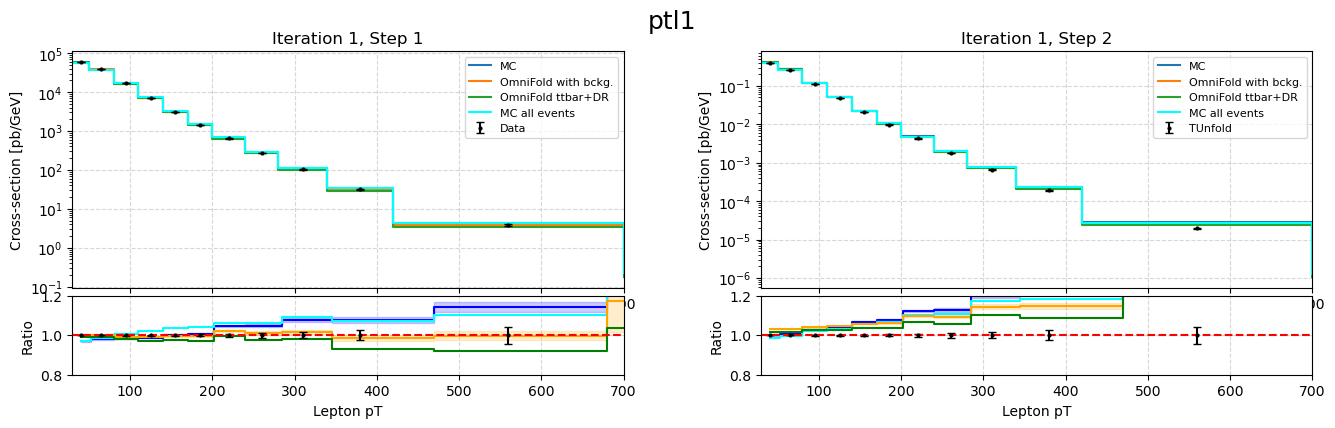

In [86]:
n_iterations = 1
obs_name = "ptl1"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled[:,0,0] if stepn == 1 else Y_truth_scaled[:,0,0]

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_5000000_pythia_WbWb_background_1Dptl1"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0][pythia_unmatched["pass_matched"]!=0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"][pythia_unmatched["pass_matched"]!=0] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 0, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    #acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 0, 0]
                values_mc_all = pythia_reco_background[:, 0, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 0, 0], bins=edges,
                    weights=data_df["eventWeight"]*0.75
                )
                #data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 0, 0]
                values_mc_all = pythia_truth_background[:, 0, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_all, _ = np.histogram(
                values_mc_all, bins=edges,
                weights=pythia_background["eventWeight"]*pythia_background["pass_reco"]*0.75 if stepn==1 else pythia_background["eventWeight"]*pythia_background["pass_particle"]*SF
            )
            counts_mc_density = counts_mc / bin_widths
            counts_all_density = counts_mc_all / bin_widths
            counts_all_density *= efficiency if stepn ==2 else 1.0
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            counts_omnifold_bckg, _ = np.histogram(
                values_mc[pythia_test["channel"]!=2], bins=edges,
                weights=((testset_loader.weight*unfolded_weights)[pythia_test["channel"]!=2] if stepn==1 else (testset_loader.weight*weights_push*SF)[pythia_test["channel"]!=2])
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            counts_omnifold_bckg_density = counts_omnifold_bckg / bin_widths
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold with bckg.')
            ax_main.step(edges[:-1], counts_omnifold_bckg_density, where='post', label='OmniFold ttbar+DR')
            ax_main.step(edges[:-1], counts_all_density, where='post', color='cyan', label='MC all events')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density
            ratio_omnifold_bckg = counts_omnifold_bckg_density / data_density
            ratio_mc_all = counts_all_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )
            ax_ratio.step(bin_centers, ratio_mc_all, where='mid', color='cyan', label='MC all events / Data')
            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )
            ax_ratio.step(bin_centers, ratio_omnifold_bckg, where='mid', color='green', label='OmniFold ttbar+DR / Data')

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.8, 1.2)
            ax_ratio.set_xlabel("Lepton pT")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

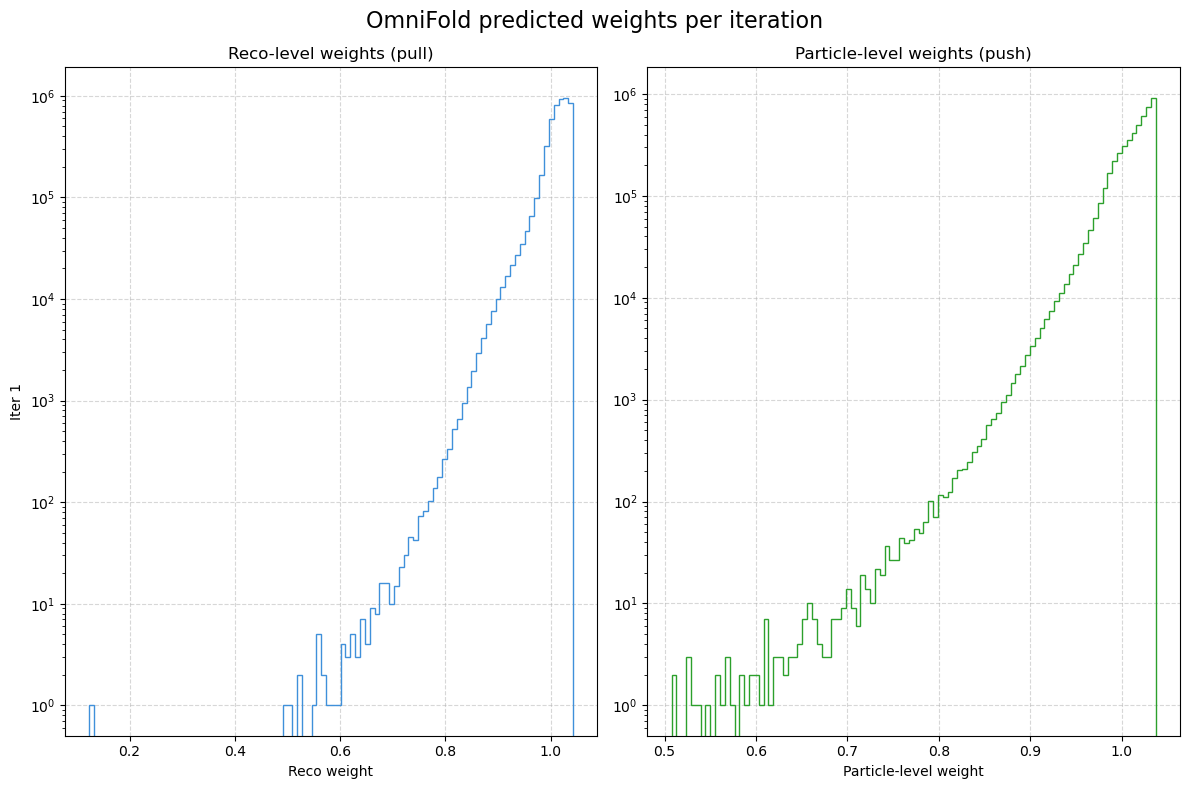

1.0127460470892982 1.0128431


In [ ]:
n_iterations = len(weights_pull_list)

fig, axes = plt.subplots(
    n_iterations, 2,
    figsize=(12, 8),
    #sharex="col",
    sharey="col"
)

for it in range(n_iterations):
    ax = axes[0]

    ax.hist(
        weights_pull_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#3f90da",
    )
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)

    if it == 0:
        ax.set_title("Reco-level weights (pull)")
    ax.set_ylabel(f"Iter {it+1}")
    ax = axes[1]
    ax.hist(
        weights_push_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#2ca02c",
    )
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)
    if it == 0:
        ax.set_title("Particle-level weights (push)")

# X-labels only on bottom row
axes[0].set_xlabel("Reco weight")
axes[1].set_xlabel("Particle-level weight")

fig.suptitle(
    "OmniFold predicted weights per iteration",
    fontsize=16
)
plt.tight_layout()
plt.show()
print(np.mean(weights_pull_list[it]), np.mean(weights_push_list[it]))


In [62]:
data_loader = DataLoader(reco = X_data_scaled[:,1,0], weight = data_df['eventWeight']*0.8, normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled[:,1,0], gen = X_pythia_truth_scaled[:,1,0], weight = pythia_train['eventWeight'],normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test[:,1,0], gen = pythia_truth_test[:,1,0], weight = pythia_test['eventWeight'],normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


In [63]:
model1 = MLP(1)
model2 = MLP(1)
weight_folder = '/scratch/mjosef/Unfolding/omnifold/data/'

omnifold = omnifold_routine.MultiFold(
    "5000000_pythia_WbWb_background_1Dptb1",
    model1, # model_reco
    model2, # model_gen
    data_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 1,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=5,
    lr = 5e-4,
)
#omnifold.Unfold()

72671 training steps at reco and 78125 steps at gen


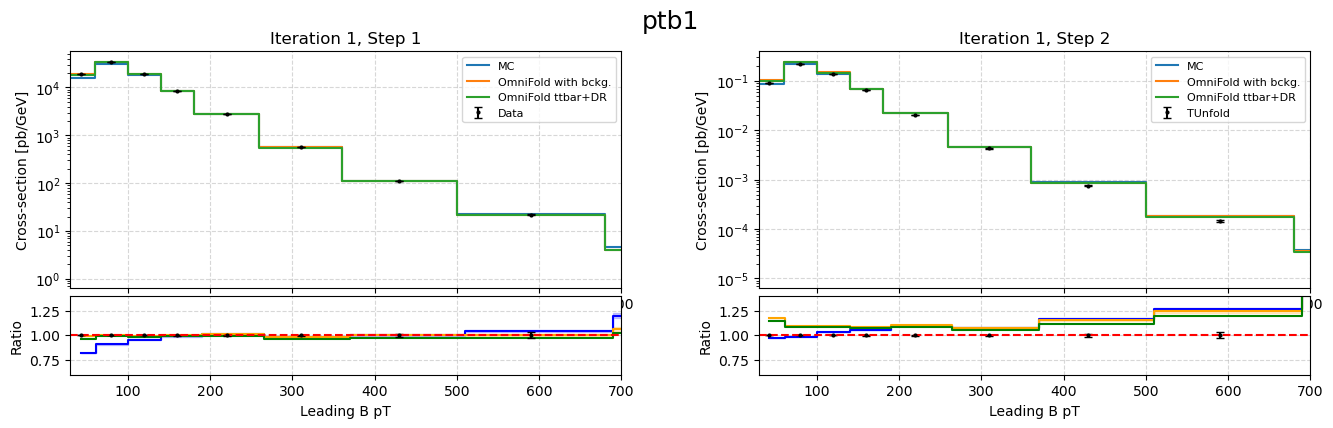

In [64]:
n_iterations = 1
obs_name = "ptb1"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled[:,1,0] if stepn == 1 else Y_truth_scaled[:,1,0]

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_5000000_pythia_WbWb_background_1Dptb1"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 1, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 1, 0][pythia_unmatched["pass_matched"]!=0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"][pythia_unmatched["pass_matched"]!=0] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 1, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 1, 0][pythia_reco_unmatched[:, 1, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 1, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    #acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 1, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 1, 0], bins=edges,
                    weights=data_df["eventWeight"]*0.8
                )
                #data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 1, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_density = counts_mc / bin_widths
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            counts_omnifold_bckg, _ = np.histogram(
                values_mc[pythia_test["channel"]!=2], bins=edges,
                weights=((testset_loader.weight*unfolded_weights)[pythia_test["channel"]!=2] if stepn==1 else (testset_loader.weight*weights_push*SF)[pythia_test["channel"]!=2])
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            counts_omnifold_bckg_density = counts_omnifold_bckg / bin_widths
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold with bckg.')
            ax_main.step(edges[:-1], counts_omnifold_bckg_density, where='post', label='OmniFold ttbar+DR')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density
            ratio_omnifold_bckg = counts_omnifold_bckg_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )

            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )
            ax_ratio.step(bin_centers, ratio_omnifold_bckg, where='mid', color='green', label='OmniFold ttbar+DR / Data')

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.6, 1.4)
            ax_ratio.set_xlabel("Leading B pT")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

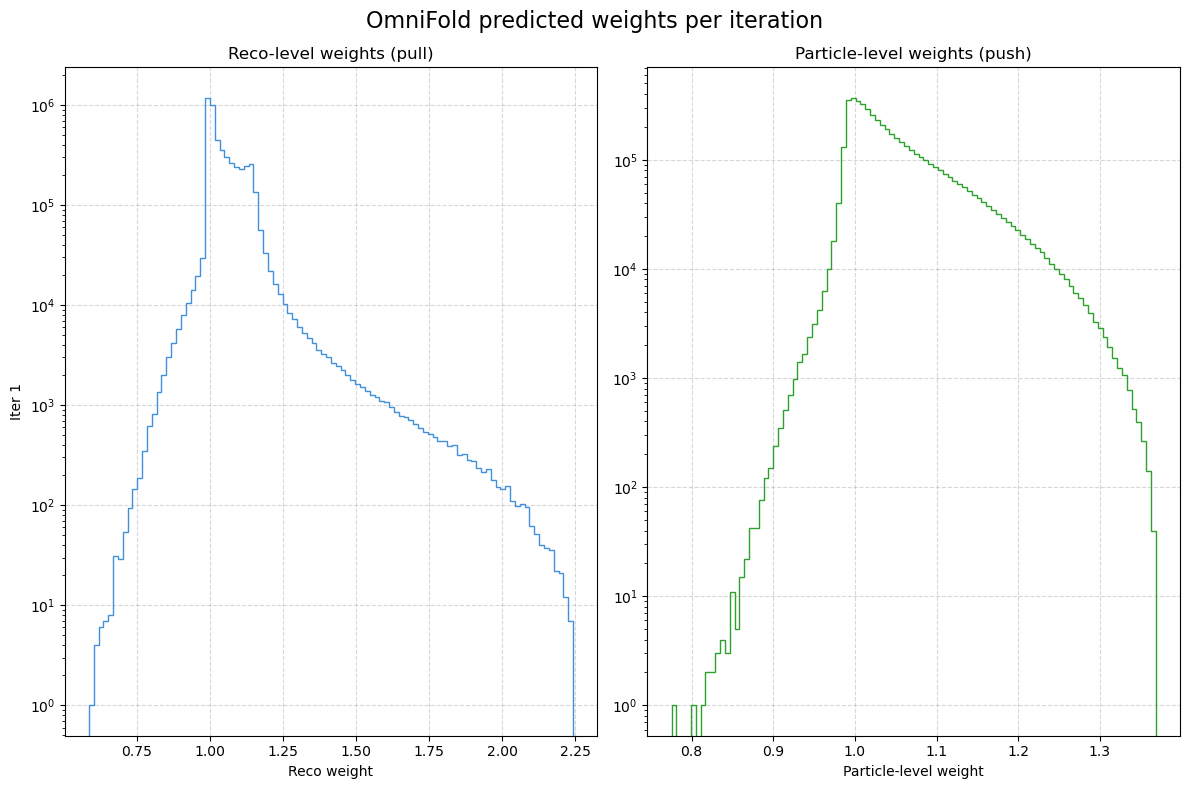

1.0522610514114976 1.0533574


In [41]:
n_iterations = len(weights_pull_list)

fig, axes = plt.subplots(
    n_iterations, 2,
    figsize=(12, 8),
    #sharex="col",
    sharey="col"
)
for it in range(n_iterations):

    # =========================
    # Reco-level weights
    # =========================
    ax = axes[0]
    ax.hist(
        weights_pull_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#3f90da",)
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)
    if it == 0:
        ax.set_title("Reco-level weights (pull)")
    ax.set_ylabel(f"Iter {it+1}")
    ax = axes[1]
    ax.hist(
        weights_push_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#2ca02c",
    )
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)
    if it == 0:
        ax.set_title("Particle-level weights (push)")
# X-labels only on bottom row
axes[0].set_xlabel("Reco weight")
axes[1].set_xlabel("Particle-level weight")
fig.suptitle(
    "OmniFold predicted weights per iteration",
    fontsize=16
)
plt.tight_layout()
plt.show()
print(np.mean(weights_pull_list[it]), np.mean(weights_push_list[it]))

In [42]:
data_loader = DataLoader(reco = X_data_scaled[:,11,0], weight = data_df['eventWeight']*0.8, normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled[:,11,0], gen = X_pythia_truth_scaled[:,11,0], weight = pythia_train['eventWeight'],normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test[:,11,0], gen = pythia_truth_test[:,11,0], weight = pythia_test['eventWeight'],normalize=False)
model1 = MLP(1)
model2 = MLP(1)
weight_folder = '/scratch/mjosef/Unfolding/omnifold/data/'

omnifold = omnifold_routine.MultiFold(
    "5000000_pythia_WbWb_background_1Dmet",
    model1, # model_reco
    model2, # model_gen
    data_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 1,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=5,
    lr = 5e-4,
)
omnifold.Unfold()

INFO: Creating pass reco flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
72671 training steps at reco and 78125 steps at gen
ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 9301888, Test events used: 1860377
################################################################################
Epoch 1/100


2026-01-13 12:53:51.379807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:325,RepeatDataset:326): Filling up shuffle buffer (this may take a while): 4888599 of 7441511
2026-01-13 12:53:56.648564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


58136/58136 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 0.4902 - val_loss: 0.4907 - learning_rate: 5.0000e-04
Epoch 2/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - loss: 0.4902 - val_loss: 0.4906 - learning_rate: 5.0000e-04
Epoch 3/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step - loss: 0.4901 - val_loss: 0.4907 - learning_rate: 5.0000e-04
Epoch 4/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step - loss: 0.4901 - val_loss: 0.4906 - learning_rate: 5.0000e-04
Epoch 5/100
58104/58136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4904
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step - loss: 0.4904 - val_loss: 0.4907 - learning_rate: 5.0000e-04
Epoch 6/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 111s 2ms/step - loss: 0.4902 - val_loss: 0.4906 - learning_rate: 5.0000e-05
Epoch 7/100
58136/58136 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - loss: 0.4901 - val_loss: 0.4906 - learning_rate: 5.0000e-05
Epoch 8/100
58136/58136 ━━━━

2026-01-13 13:19:27.330845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:352,RepeatDataset:353): Filling up shuffle buffer (this may take a while): 4879694 of 8000001
2026-01-13 13:19:33.977430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


62500/62500 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - loss: 0.4563 - val_loss: 0.4560 - learning_rate: 5.0000e-04
Epoch 2/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 0.4565 - val_loss: 0.4560 - learning_rate: 5.0000e-04
Epoch 3/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - loss: 0.4566 - val_loss: 0.4560 - learning_rate: 5.0000e-04
Epoch 4/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 0.4569 - val_loss: 0.4560 - learning_rate: 5.0000e-04
Epoch 5/100
62479/62500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4562
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 0.4562 - val_loss: 0.4561 - learning_rate: 5.0000e-04
Epoch 6/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - loss: 0.4566 - val_loss: 0.4560 - learning_rate: 5.0000e-05
Epoch 7/100
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 0.4564 - val_loss: 0.4560 - learning_rate: 5.0000e-05
Epoch 8/100
62500/62500 ━━━━

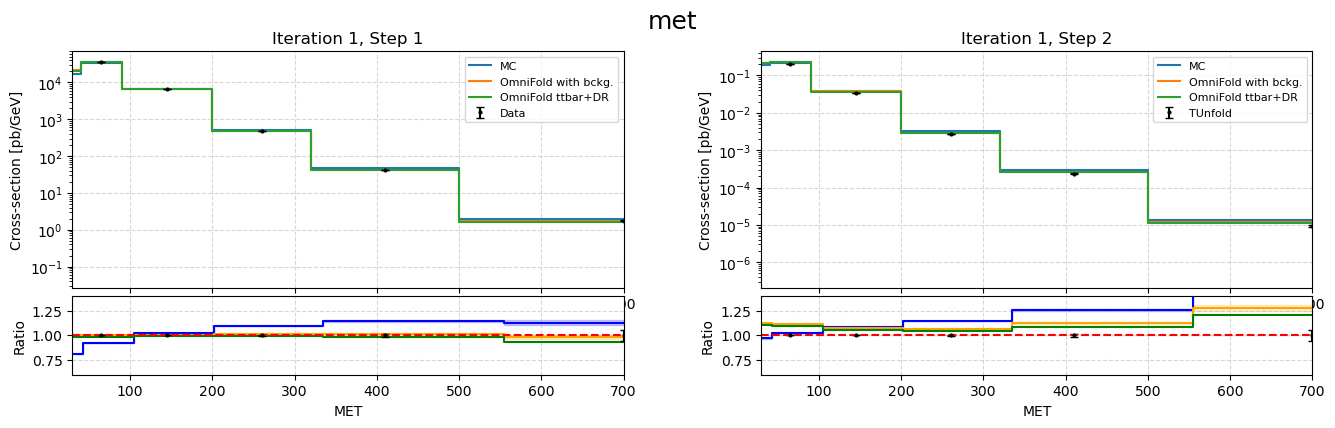

In [57]:
n_iterations = 1
obs_name = "met"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled[:,11,0] if stepn == 1 else Y_truth_scaled[:,11,0]

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_5000000_pythia_WbWb_background_1Dmet"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 11, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 11, 0][pythia_unmatched["pass_matched"]!=0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"][pythia_unmatched["pass_matched"]!=0] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 11, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 11, 0][pythia_reco_unmatched[:, 11, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 11, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    #acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 11, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 11, 0], bins=edges,
                    weights=data_df["eventWeight"]*0.8
                )
                #data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 11, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_density = counts_mc / bin_widths
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            counts_omnifold_bckg, _ = np.histogram(
                values_mc[pythia_test["channel"]!=2], bins=edges,
                weights=((testset_loader.weight*unfolded_weights)[pythia_test["channel"]!=2] if stepn==1 else (testset_loader.weight*weights_push*SF)[pythia_test["channel"]!=2])
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            counts_omnifold_bckg_density = counts_omnifold_bckg / bin_widths
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold with bckg.')
            ax_main.step(edges[:-1], counts_omnifold_bckg_density, where='post', label='OmniFold ttbar+DR')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density
            ratio_omnifold_bckg = counts_omnifold_bckg_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )

            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )
            ax_ratio.step(bin_centers, ratio_omnifold_bckg, where='mid', color='green', label='OmniFold ttbar+DR / Data')

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.6, 1.4)
            ax_ratio.set_xlabel("MET")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

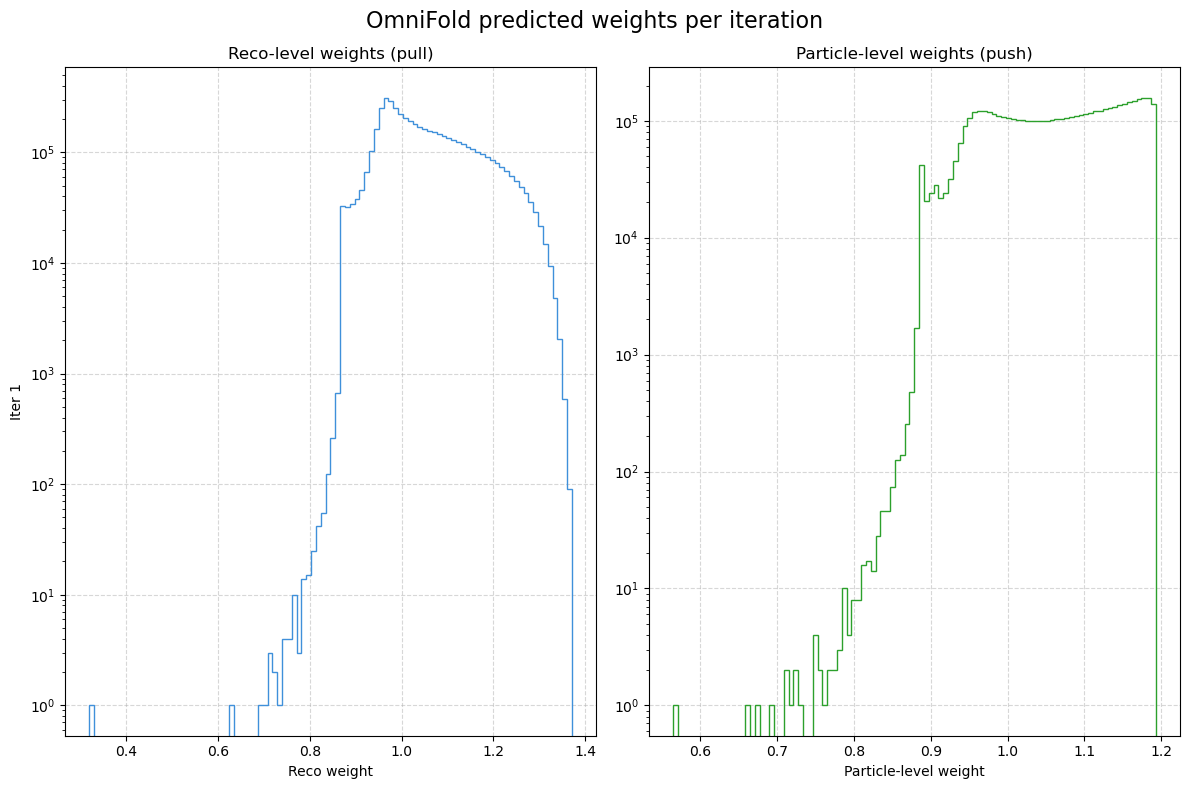

1.058986872447771 1.0652391


In [44]:
n_iterations = len(weights_pull_list)
fig, axes = plt.subplots(
    n_iterations, 2,
    figsize=(12, 8),
    sharey="col"
)
for it in range(n_iterations):

    # =========================
    # Reco-level weights
    # =========================
    ax = axes[0]
    ax.hist(
        weights_pull_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#3f90da",)
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)
    if it == 0:
        ax.set_title("Reco-level weights (pull)")
    ax.set_ylabel(f"Iter {it+1}")
    ax = axes[1]
    ax.hist(
        weights_push_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#2ca02c",
    )
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)
    if it == 0:
        ax.set_title("Particle-level weights (push)")
# X-labels only on bottom row
axes[0].set_xlabel("Reco weight")
axes[1].set_xlabel("Particle-level weight")
fig.suptitle(
    "OmniFold predicted weights per iteration",
    fontsize=16
)
plt.tight_layout()
plt.show()
print(np.mean(weights_pull_list[it]), np.mean(weights_push_list[it]))

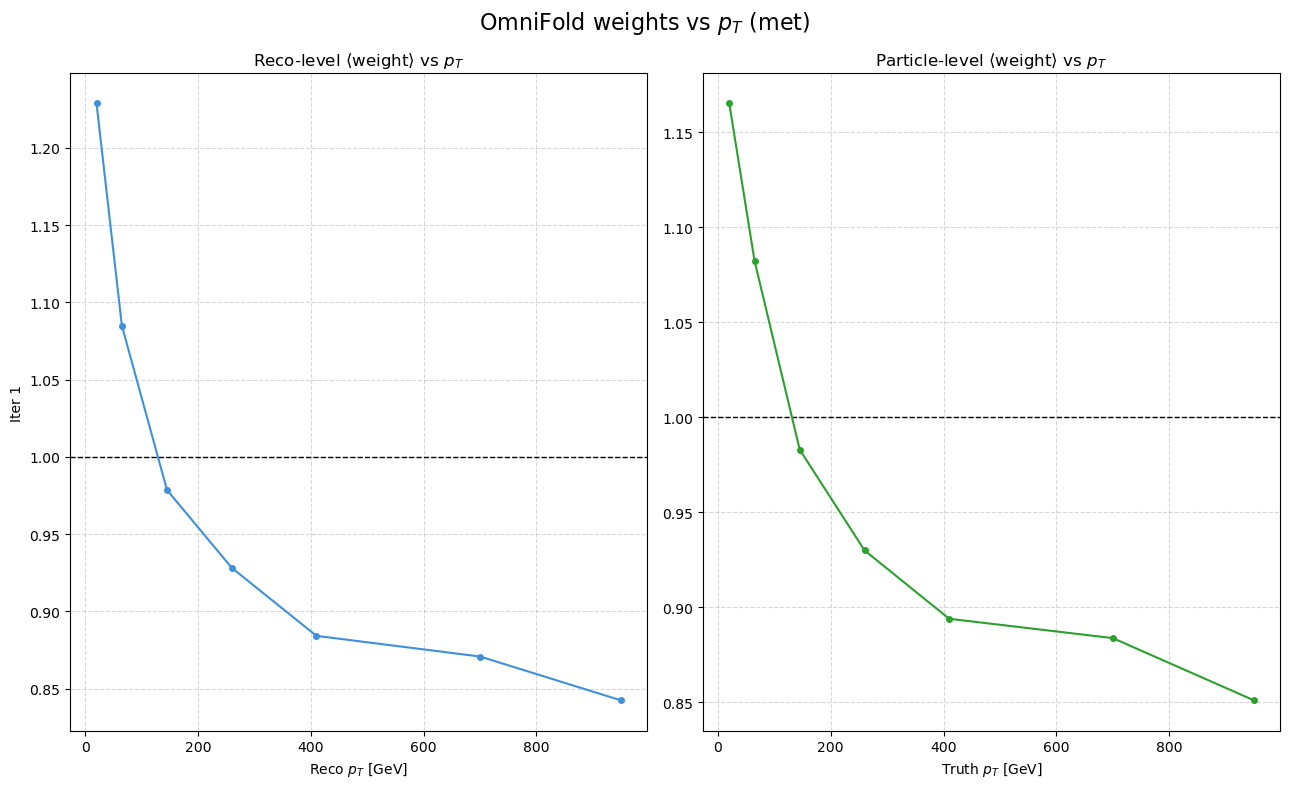

In [ ]:
def profile_weight(x, w, bins):
    """
    Compute mean weight and error per x-bin
    """
    centers = 0.5 * (bins[:-1] + bins[1:])
    mean = np.zeros(len(centers))
    err  = np.zeros(len(centers))

    for i in range(len(centers)):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mean[i] = np.mean(w[mask])
            err[i]  = np.std(w[mask]) / np.sqrt(np.sum(mask))
        else:
            mean[i] = np.nan
            err[i]  = np.nan

    return centers, mean, err


n_iterations = len(weights_pull_list)
hist = TUnfold_incl_file[f"unfolding_met_NOSYS"]
edges = hist.axis().edges()
bins=edges
fig, axes = plt.subplots(
    n_iterations, 2,
    figsize=(13, 8),
    sharex="col",
    sharey=False
)

for it in range(n_iterations):

    # =========================
    # Reco level
    # =========================
    ax = axes[0]

    x = pythia_reco_test[:, 11, 0]
    w = weights_pull_list[it]

    centers, mean, err = profile_weight(x, w, bins)

    ax.errorbar(
        centers, mean, yerr=err,
        fmt="o-", lw=1.5, ms=4,
        color="#3f90da"
    )

    ax.axhline(1.0, color="black", ls="--", lw=1)
    #ax.set_xscale("log")
    ax.grid(True, ls="--", alpha=0.5)

    if it == 0:
        ax.set_title("Reco-level ⟨weight⟩ vs $p_T$")
    ax.set_ylabel(f"Iter {it+1}")

    # =========================
    # Particle level
    # =========================
    ax = axes[1]

    x = pythia_truth_test[:, 11, 0]
    w = weights_push_list[it]

    centers, mean, err = profile_weight(x, w, bins)

    ax.errorbar(
        centers, mean, yerr=err,
        fmt="o-", lw=1.5, ms=4,
        color="#2ca02c"
    )

    ax.axhline(1.0, color="black", ls="--", lw=1)
    #ax.set_xscale("log")
    ax.grid(True, ls="--", alpha=0.5)

    if it == 0:
        ax.set_title("Particle-level ⟨weight⟩ vs $p_T$")

# X-labels
axes[0].set_xlabel("Reco $p_T$ [GeV]")
axes[1].set_xlabel("Truth $p_T$ [GeV]")

fig.suptitle(
    f"OmniFold weights vs $p_T$ (met)",
    fontsize=16
)

plt.tight_layout()
plt.show()


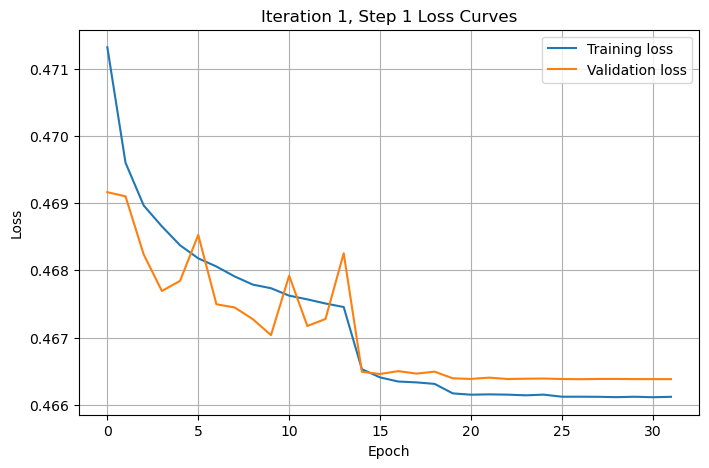

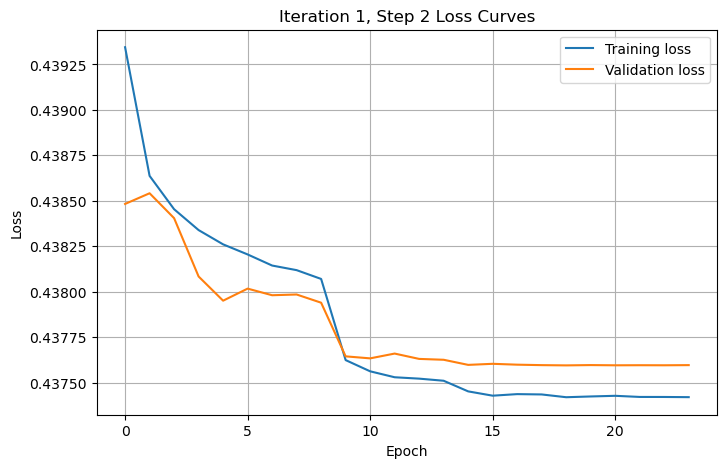

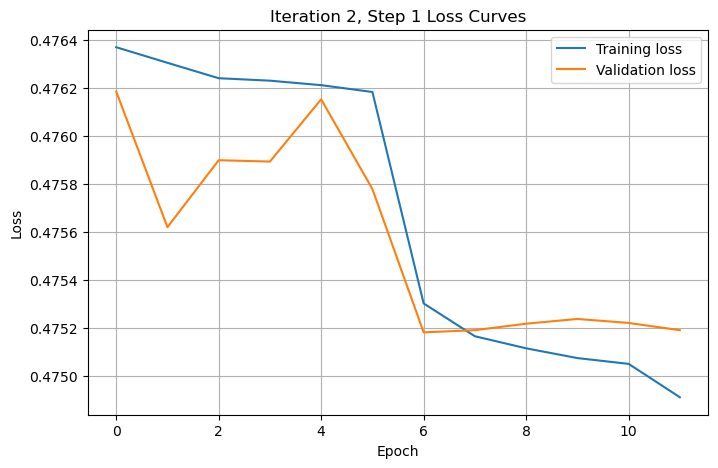

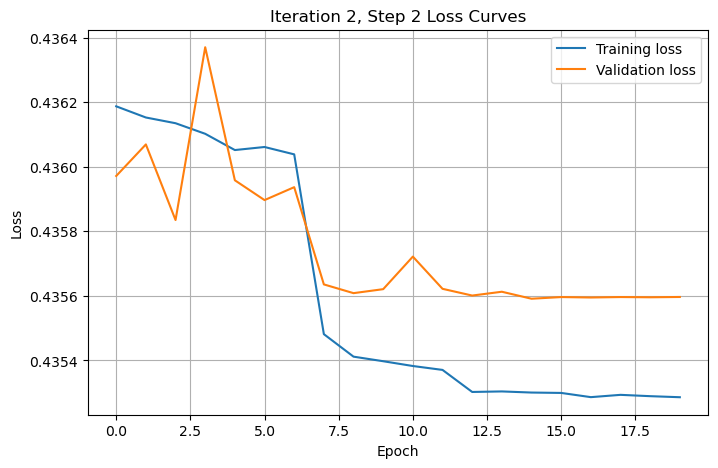

In [9]:
import pickle
# Set these to your parameters
weights_folder = weight_folder      
niter = 2                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


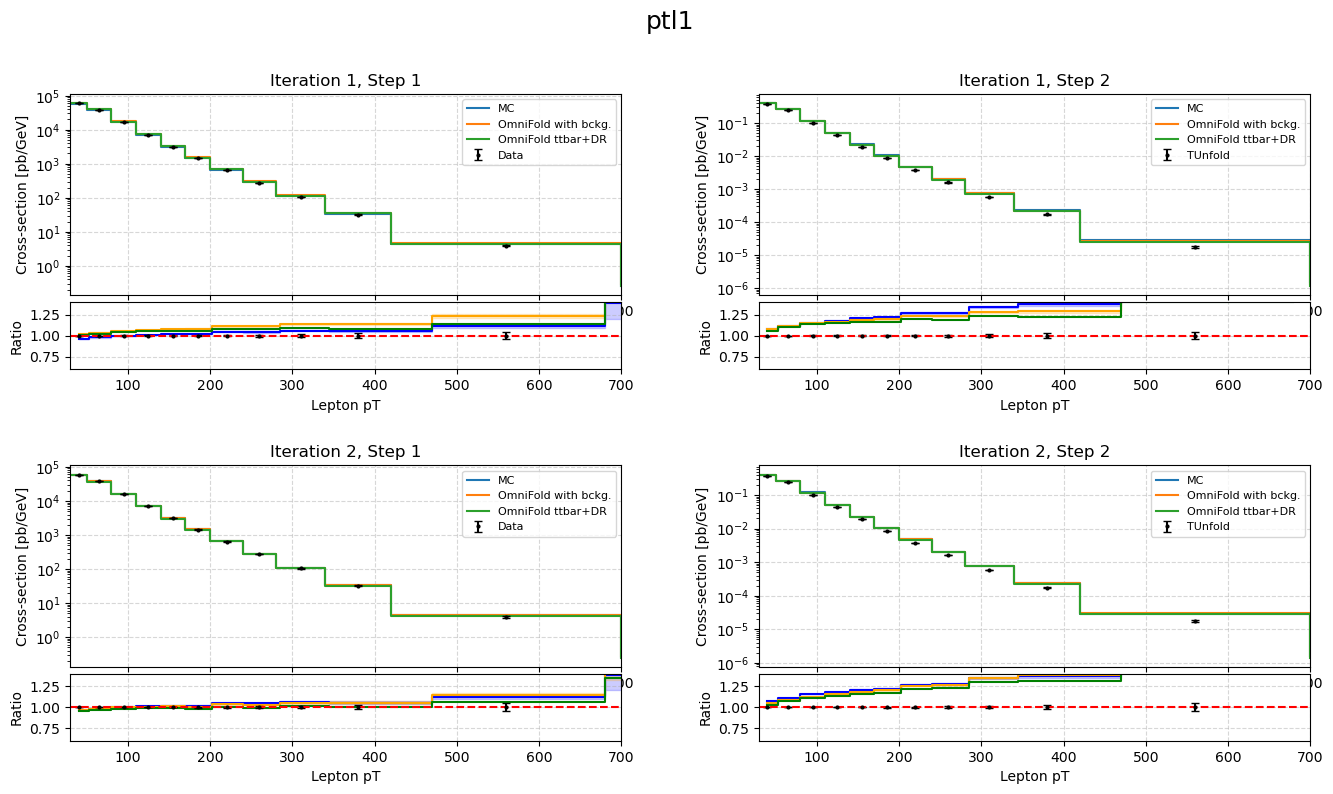

In [10]:
n_iterations = 2
obs_name = "ptl1"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled if stepn == 1 else Y_truth_scaled

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_{omnifold_name}"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 0, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 0, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 0, 0], bins=edges,
                    weights=data_df["eventWeight"]
                )
                data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 0, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_density = counts_mc / bin_widths
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            counts_omnifold_bckg, _ = np.histogram(
                values_mc[pythia_test["channel"]!=2], bins=edges,
                weights=((testset_loader.weight*unfolded_weights)[pythia_test["channel"]!=2] if stepn==1 else (testset_loader.weight*weights_push*SF)[pythia_test["channel"]!=2])
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            counts_omnifold_bckg_density = counts_omnifold_bckg / bin_widths
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold with bckg.')
            ax_main.step(edges[:-1], counts_omnifold_bckg_density, where='post', label='OmniFold ttbar+DR')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density
            ratio_omnifold_bckg = counts_omnifold_bckg_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )

            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )
            ax_ratio.step(bin_centers, ratio_omnifold_bckg, where='mid', color='green', label='OmniFold ttbar+DR / Data')

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.6, 1.4)
            ax_ratio.set_xlabel("Lepton pT")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1768291335.707015  938604 service.cc:152] XLA service 0x7fba9c00fdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768291335.707049  938604 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2026-01-13 09:02:15.771179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768291335.914787  938604 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1768291337.324182  

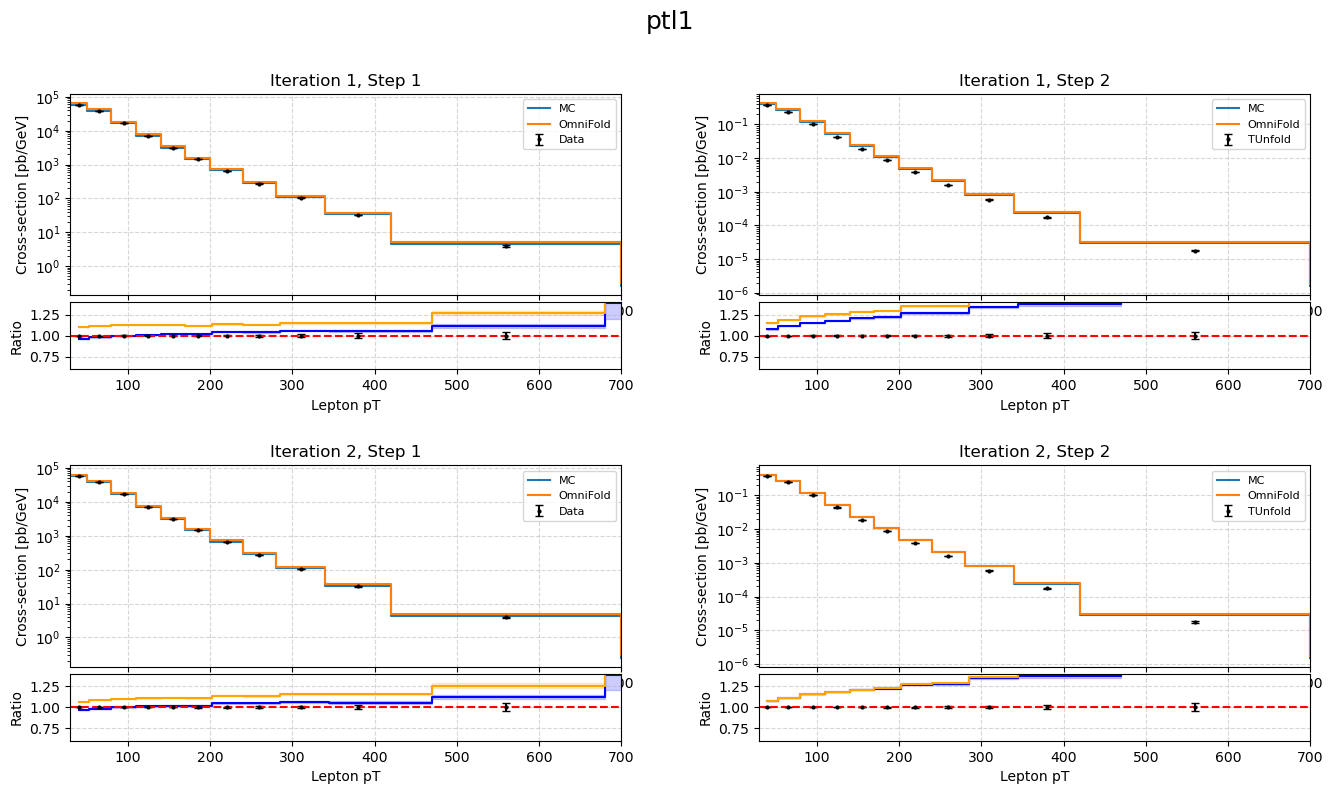

In [ ]:
n_iterations = 2
obs_name = "ptl1"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled if stepn == 1 else Y_truth_scaled

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_{omnifold_name}"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 0, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 0, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 0, 0], bins=edges,
                    weights=data_df["eventWeight"]
                )
                data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 0, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_density = counts_mc / bin_widths
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            counts_omnifold_bckg, _ = np.histogram(
                values_mc[pythia_test["channel"]!=2], bins=edges,
                weights=((testset_loader.weight*unfolded_weights)[pythia_test["channel"]!=2] if stepn==1 else (testset_loader.weight*weights_push*SF)[pythia_test["channel"]!=2])
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            counts_omnifold_bckg_density = counts_omnifold_bckg / bin_widths
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold with bckg.')
            ax_main.step(edges[:-1], counts_omnifold_bckg_density, where='post', label='OmniFold ttbar+DR')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )

            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.6, 1.4)
            ax_ratio.set_xlabel("Lepton pT")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

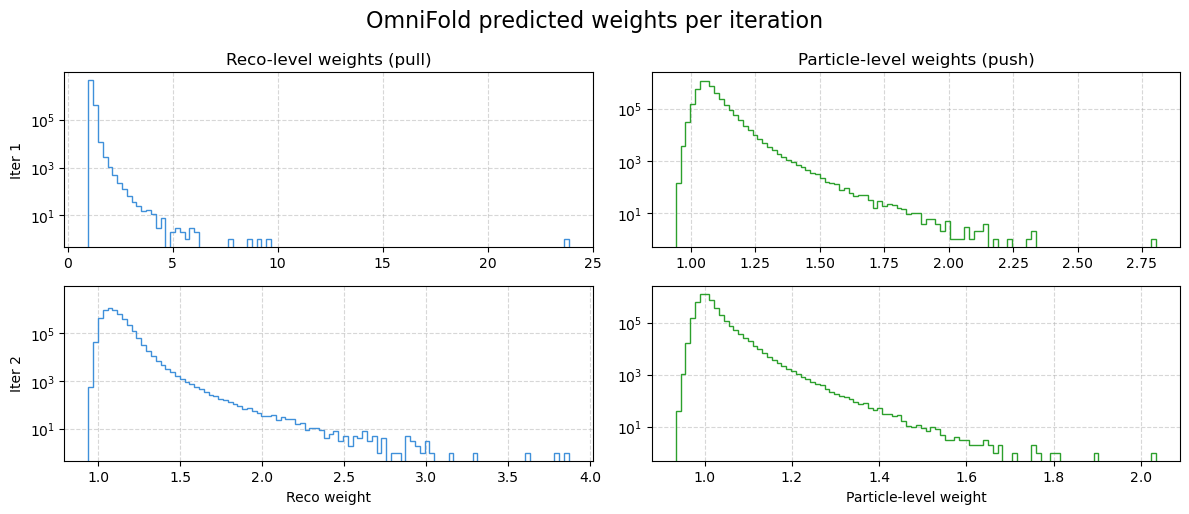

In [11]:
n_iterations = len(weights_pull_list)

fig, axes = plt.subplots(
    n_iterations, 2,
    figsize=(12, 2.6 * n_iterations),
    #sharex="col",
    sharey="col"
)

# Common binning for weights (log-spaced is best)
#wmin, wmax = 1e-2, 1e2
#bins = np.logspace(np.log10(wmin), np.log10(wmax), 60)

for it in range(n_iterations):

    # =========================
    # Reco-level weights
    # =========================
    ax = axes[it, 0]

    ax.hist(
        weights_pull_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#3f90da",
    )

    #ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)

    if it == 0:
        ax.set_title("Reco-level weights (pull)")
    ax.set_ylabel(f"Iter {it+1}")

    # =========================
    # Particle-level weights
    # =========================
    ax = axes[it, 1]

    ax.hist(
        weights_push_list[it],
        bins=100,
        histtype="step",
        lw=1.8,
        color="#2ca02c",
    )

    #ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, ls="--", alpha=0.5)

    if it == 0:
        ax.set_title("Particle-level weights (push)")

# X-labels only on bottom row
axes[-1, 0].set_xlabel("Reco weight")
axes[-1, 1].set_xlabel("Particle-level weight")

fig.suptitle(
    "OmniFold predicted weights per iteration",
    fontsize=16
)

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1767948116.419790 2975821 service.cc:152] XLA service 0x7f02c0013bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767948116.419822 2975821 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2026-01-09 09:41:56.485044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767948116.629773 2975821 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1767948118.098539

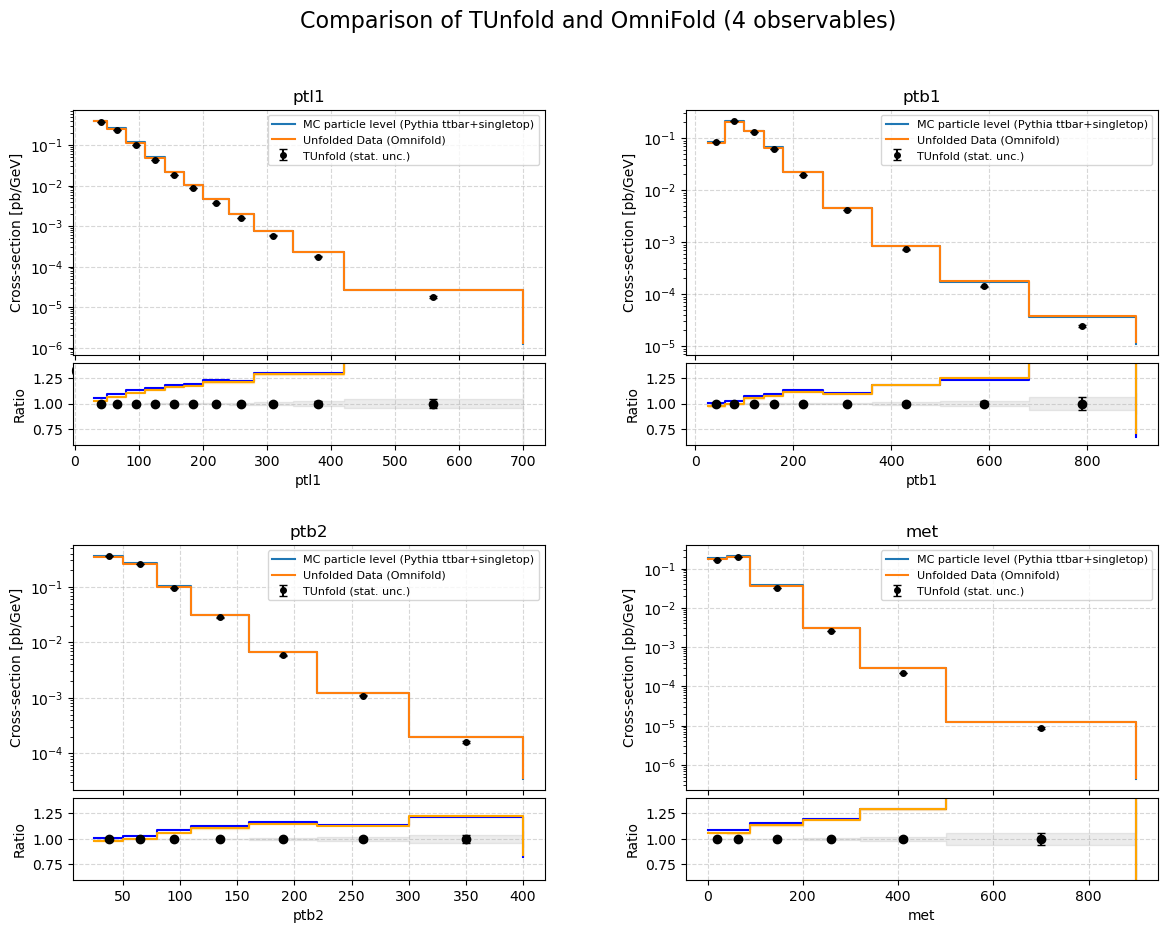

In [23]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1 / luminosity)

# -------------------------------
# Observables to plot (4 total)
# -------------------------------
observables = {
    "ptl1": 0,  # lepton pt
    "ptb1": 1,
    "ptb2": 2,
    "met": 11,
}
def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled if stepn == 1 else Y_truth_scaled

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_{omnifold_name}"
            f"_iter{it}_step{stepn}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg
unfolded_weights = load_updated_weights(it=2, stepn=2, batch_size=1000)
# -------------------------------
# Set up figure: 2×2 grid, each cell = (main + ratio)
# -------------------------------
fig = plt.figure(figsize=(14, 10))
outer_gs = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.3)

for idx, (obs_name, obs_index) in enumerate(observables.items()):
    # Determine grid position
    row, col = divmod(idx, 2)
    inner_gs = outer_gs[row, col].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.05)

    ax_main = fig.add_subplot(inner_gs[0])
    ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)

    # --- Load histograms from file ---
    hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
    rel_pt_up = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1up;1']
    rel_pt_down = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1down;1']
    values = hist.values()
    edges = hist.axis().edges()
    bin_widths = np.diff(edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    matched_hist, _ = np.histogram(
            pythia_truth_matched[:, obs_index, 0],
            bins=edges,
            weights=pythia_matched['eventWeight'] * SF
        )
    unmatched_hist, _ = np.histogram(
            pythia_truth_unmatched[:, obs_index, 0],
            bins=edges,
            weights=pythia_unmatched['eventWeight'] * SF
        )

    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, obs_index, 0],
        bins=edges,
        weights=pythia_matched['eventWeight'] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, obs_index, 0][pythia_reco_unmatched[:, obs_index, 0]!=0],
        bins=edges,
        weights=(pythia_unmatched['eventWeight'] * SF)[pythia_reco_unmatched[:, obs_index, 0]!=0]
    )
    # Efficiency
    efficiency = np.zeros_like(unmatched_hist, dtype=float)
    efficiency = matched_hist / unmatched_hist

    # Acceptance
    acceptance = np.zeros_like(reco_matched_hist, dtype=float)
    acceptance = reco_matched_hist / reco_unmatched_hist
    values = values*efficiency
    rel_unc_up_tunfold = rel_pt_up.values()
    rel_unc_down_tunfold = rel_pt_down.values()

    # --- Prepare Omnifold weights ---
    weights_omnifold = (unfolded_weights * pythia_test['eventWeight']*pythia_test["pass_particle"]) * SF
    weights_omnifold2 = weights_omnifold**2
    values_omnifold = pythia_truth_test[:, obs_index, 0]

    # --- Histogram Omnifold ---
    counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
    counts2_density = counts2 / bin_widths
    sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

    # --- Histogram Pythia reference ---
    counts1, _ = np.histogram(
        pythia_truth_test[:, obs_index, 0][pythia_truth_test[:, obs_index, 0]!=0],
        bins=edges,
        weights=(pythia_test['eventWeight']*pythia_test["pass_particle"] * SF)
    )
    counts1_density = counts1 / bin_widths
    values_density = values / bin_widths

    # --- Plot main panel ---
    ax_main.step(edges[:-1], counts1_density, where="post", label='MC particle level (Pythia ttbar+singletop)')
    ax_main.step(edges[:-1], counts2_density, where="post", label='Unfolded Data (Omnifold)')
    yerr = np.vstack((rel_unc_down_tunfold * values_density, rel_unc_up_tunfold * values_density))
    ax_main.errorbar(
        bin_centers[:-1], values_density[:-1],
        yerr=yerr[:, :-1], fmt='o', color='black', capsize=3, markersize=4,
        label="TUnfold (stat. unc.)"
    )
    ax_main.set_ylabel("Cross-section [pb/GeV]")
    ax_main.legend(fontsize=8)
    ax_main.set_yscale('log')
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.set_title(obs_name)

    # --- Plot ratio panel ---
    ratio_tunfold = np.ones_like(values_density)  # TUnfold / TUnfold
    ratio_omnifold = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density != 0)
    ratio_mc = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density != 0)

    # Step-style ratios (optional smoothing at the end)
    #ratio_tunfold_step = np.append(ratio_tunfold, ratio_tunfold[-1])
    ratio_omnifold_step = np.append(ratio_omnifold, ratio_omnifold[-1])
    ratio_mc_step = np.append(ratio_mc, ratio_mc[-1])

    # Uncertainties relative to TUnfold
    upper_omnifold = ratio_omnifold * (1 + rel_unc_omnifold)
    lower_omnifold = ratio_omnifold * (1 - rel_unc_omnifold)
    upper_tunfold = ratio_tunfold * (1 + rel_unc_up_tunfold)
    lower_tunfold = ratio_tunfold * (1 - rel_unc_down_tunfold)

    yerr_tunfold = np.vstack((ratio_tunfold * rel_unc_down_tunfold,ratio_tunfold * rel_unc_up_tunfold))

    # --- Plot ratios ---
    ax_ratio.step(edges[:-1], ratio_mc_step[:-1], where="post", color="blue", label="MC / TUnfold")
    ax_ratio.step(edges[:-1], ratio_omnifold_step[:-1], where="post", color="orange", label="OmniFold / TUnfold")
    ax_ratio.errorbar(
        bin_centers[:-1], ratio_tunfold[:-1],
        yerr=yerr_tunfold[:,:-1],
        fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
    )

    # Add uncertainty bands
    ax_ratio.fill_between(
        edges[:-1],
        lower_omnifold,
        upper_omnifold,
        step='post', alpha=0.2, color='orange', label='stat. unc. OmniFold'
    )
    ax_ratio.fill_between(
        edges[:-1],
        lower_tunfold,
        upper_tunfold,
        step='post', alpha=0.15, color='gray', label='stat. unc. TUnfold'
    )
    ax_ratio.set_xlabel(obs_name)
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.set_ylim(0.6, 1.4)
    #ax_ratio.legend(fontsize=7)
    ax_ratio.grid(True, linestyle='--', alpha=0.5)

# -------------------------------
# Final layout & save
# -------------------------------
fig.suptitle("Comparison of TUnfold and OmniFold (4 observables)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


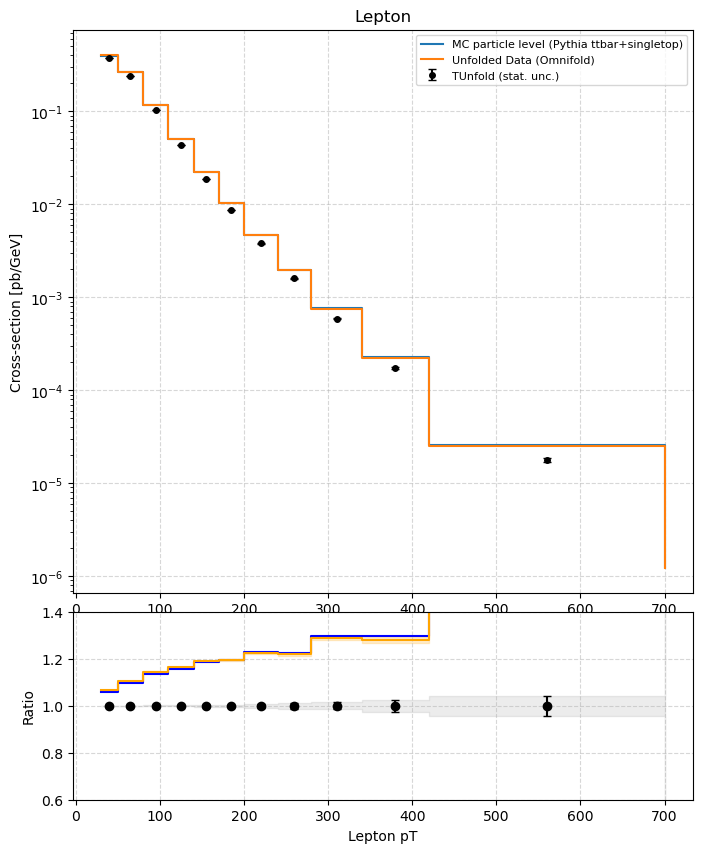

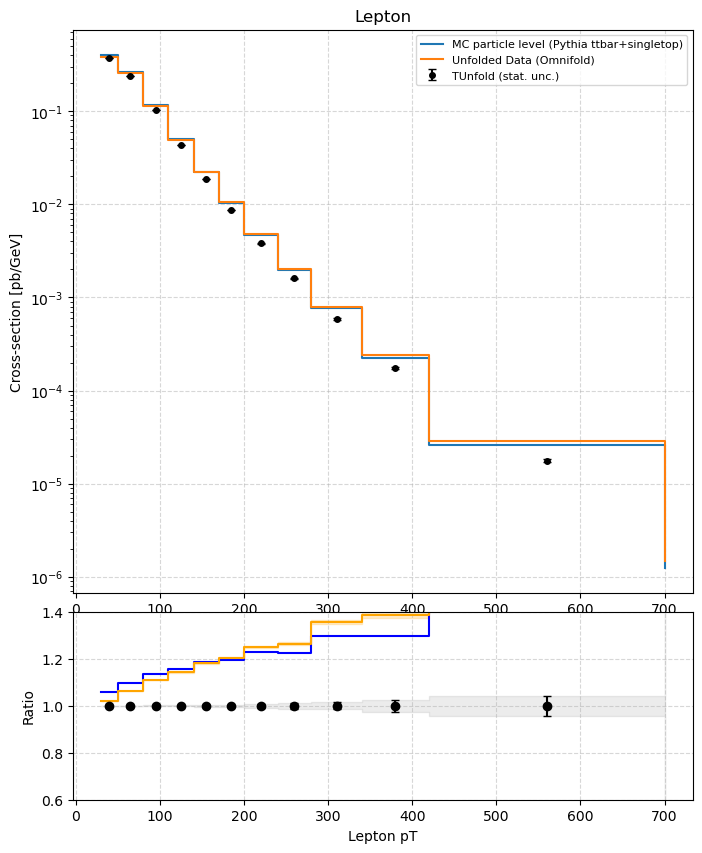

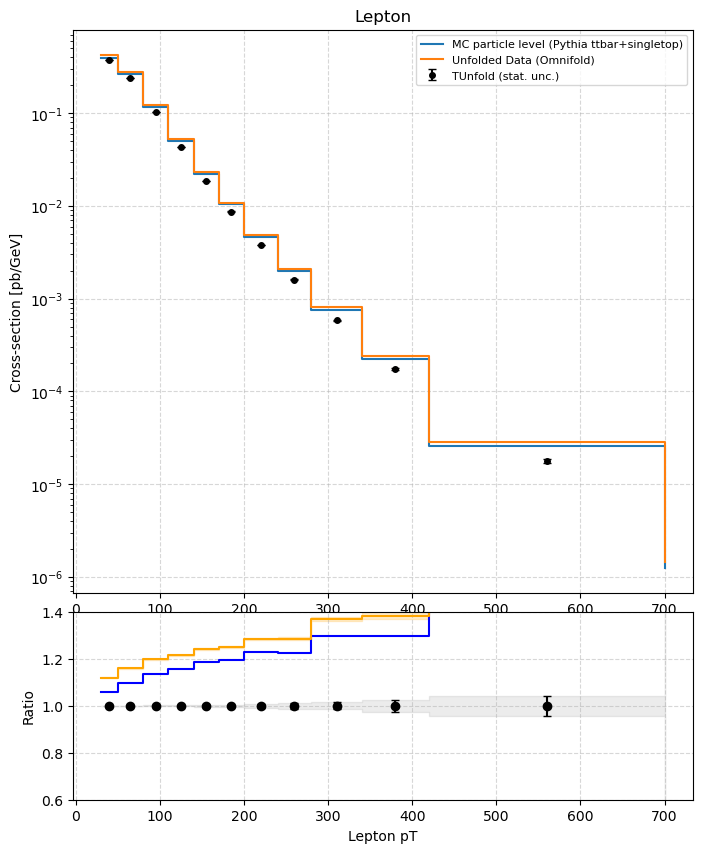

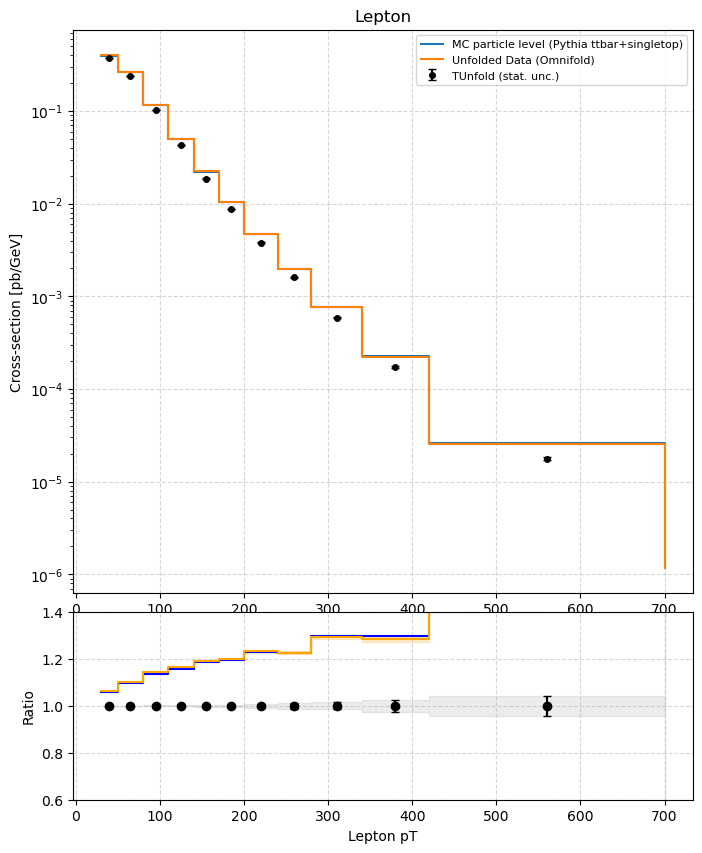

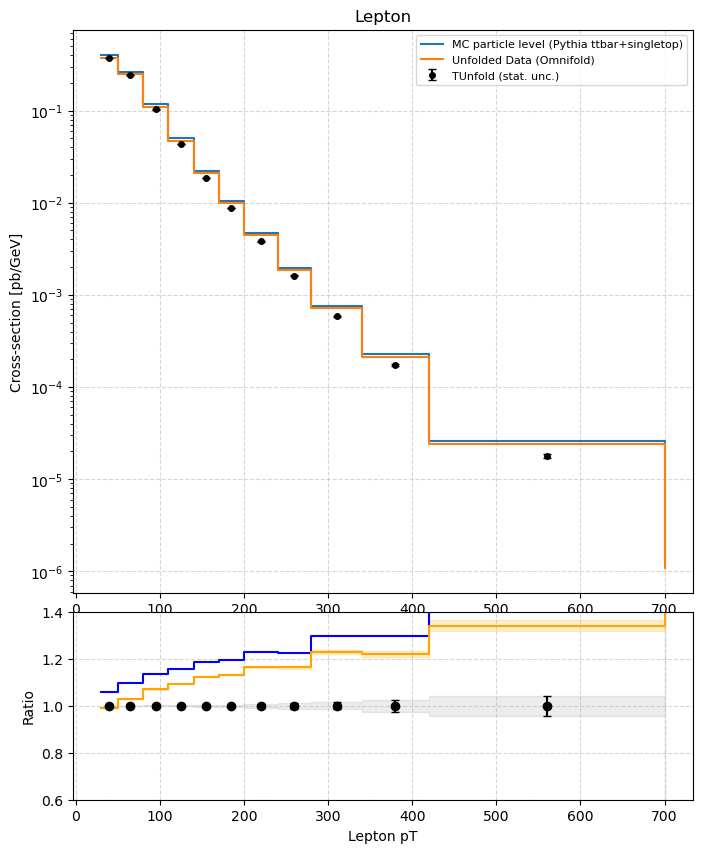

In [35]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = 1 / luminosity
for it in range(5):
    unfolded_weights = load_updated_weights(it=it, stepn=2, batch_size=1000)
    # -------------------------------
    fig = plt.figure(figsize=(8, 10))
    inner_gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax_main = fig.add_subplot(inner_gs[0])
    ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)

    # --- Load histograms from file ---
    hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
    rel_pt_up = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1up;1']
    rel_pt_down = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1down;1']

    values = hist.values()
    edges = hist.axis().edges()
    bin_widths = np.diff(edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    # --- Truth-level histograms ---
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched['eventWeight'] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched['eventWeight'] * SF
    )

    # --- Reco-level histograms ---
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched['eventWeight'] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched['eventWeight'] * SF)[pythia_reco_unmatched[:, 0, 0] != 0]
    )

    # Efficiency
    efficiency = np.zeros_like(unmatched_hist, dtype=float)
    efficiency = matched_hist / unmatched_hist

    # Acceptance
    acceptance = np.zeros_like(reco_matched_hist, dtype=float)
    acceptance = reco_matched_hist / reco_unmatched_hist

    values = values * efficiency
    rel_unc_up_tunfold = rel_pt_up.values()
    rel_unc_down_tunfold = rel_pt_down.values()

    # --- Prepare Omnifold weights ---
    weights_omnifold = (unfolded_weights * pythia_test['eventWeight']*pythia_test['pass_particle']) * SF
    weights_omnifold2 = weights_omnifold**2
    values_omnifold = pythia_truth_test[:, 0, 0]

    # --- Histogram Omnifold ---
    counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
    counts2_density = counts2 / bin_widths
    sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

    # --- Histogram Pythia reference ---
    counts1, _ = np.histogram(
        pythia_truth_test[:, 0, 0],
        bins=edges,
        weights=pythia_test['eventWeight']*pythia_test['pass_particle'] * SF
    )
    counts1_density = counts1 / bin_widths
    values_density = values / bin_widths

    # --- Plot main panel ---
    ax_main.step(edges[:-1], counts1_density, where="post", label='MC particle level (Pythia ttbar+singletop)')
    ax_main.step(edges[:-1], counts2_density, where="post", label='Unfolded Data (Omnifold)')

    yerr = np.vstack((rel_unc_down_tunfold * values_density, rel_unc_up_tunfold * values_density))
    ax_main.errorbar(
        bin_centers[:-1], values_density[:-1],
        yerr=yerr[:, :-1], fmt='o', color='black', capsize=3, markersize=4,
        label="TUnfold (stat. unc.)"
    )
    ax_main.set_ylabel("Cross-section [pb/GeV]")
    ax_main.set_yscale('log')
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=8)
    ax_main.set_title("Lepton")

    # --- Plot ratio panel ---
    ratio_tunfold = np.ones_like(values_density)  # TUnfold / TUnfold
    ratio_omnifold = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density != 0)
    ratio_mc = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density != 0)

    ratio_omnifold_step = np.append(ratio_omnifold, ratio_omnifold[-1])
    ratio_mc_step = np.append(ratio_mc, ratio_mc[-1])

    upper_omnifold = ratio_omnifold * (1 + rel_unc_omnifold)
    lower_omnifold = ratio_omnifold * (1 - rel_unc_omnifold)
    upper_tunfold = ratio_tunfold * (1 + rel_unc_up_tunfold)
    lower_tunfold = ratio_tunfold * (1 - rel_unc_down_tunfold)

    yerr_tunfold = np.vstack((ratio_tunfold * rel_unc_down_tunfold, ratio_tunfold * rel_unc_up_tunfold))

    ax_ratio.step(edges[:-1], ratio_mc_step[:-1], where="post", color="blue", label="MC / TUnfold")
    ax_ratio.step(edges[:-1], ratio_omnifold_step[:-1], where="post", color="orange", label="OmniFold / TUnfold")
    ax_ratio.errorbar(
        bin_centers[:-1], ratio_tunfold[:-1],
        yerr=yerr_tunfold[:, :-1],
        fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
    )
    ax_ratio.fill_between(edges[:-1], lower_omnifold, upper_omnifold, step='post', alpha=0.2, color='orange', label='stat. unc. OmniFold')
    ax_ratio.fill_between(edges[:-1], lower_tunfold, upper_tunfold, step='post', alpha=0.15, color='gray', label='stat. unc. TUnfold')
    ax_ratio.set_xlabel("Lepton pT")
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.set_ylim(0.6, 1.4)
    ax_ratio.grid(True, linestyle='--', alpha=0.5)

    plt.show()


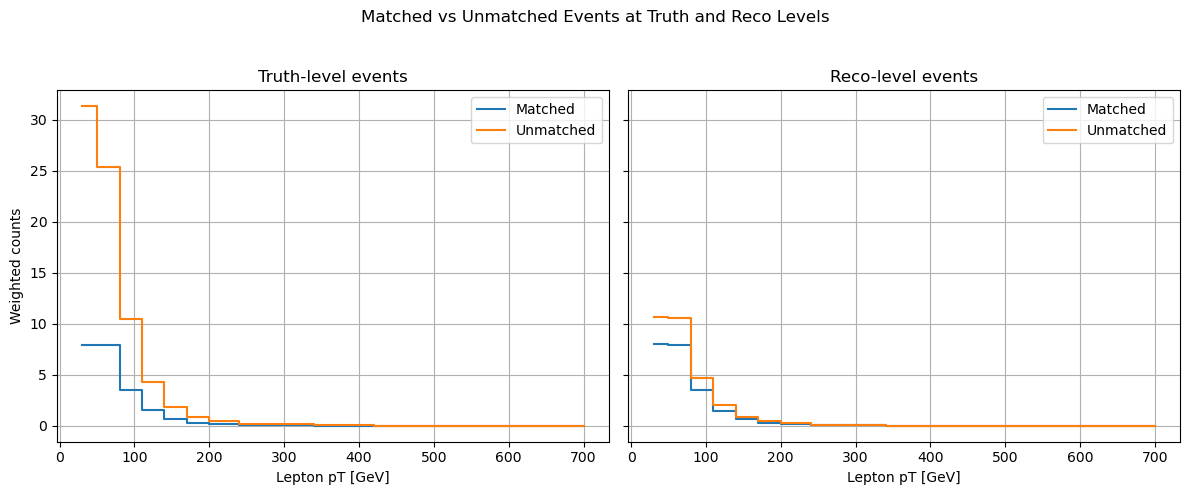

In [56]:
hist = TUnfold_incl_file[f'unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()
matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched['eventWeight'] * SF
    )
unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0][pythia_unmatched["pass_matched"]!=0],
        bins=edges,
        weights=pythia_unmatched['eventWeight'][pythia_unmatched["pass_matched"]!=0] * SF
    )

reco_matched_hist, _ = np.histogram(
    pythia_reco_matched[:, 0, 0],
    bins=edges,
    weights=pythia_matched['eventWeight'] * SF
)
reco_unmatched_hist, _ = np.histogram(
    pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0]!=0],
    bins=edges,
    weights=(pythia_unmatched['eventWeight'] * SF)[pythia_reco_unmatched[:, 0, 0]!=0]
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Truth-level plot
axes[0].step(edges[:-1], matched_hist, where="post", label='Matched')
axes[0].step(edges[:-1], unmatched_hist, where="post", label='Unmatched')
axes[0].set_title("Truth-level events")
axes[0].set_xlabel("Lepton pT [GeV]")
axes[0].set_ylabel("Weighted counts")
axes[0].legend()
axes[0].grid(True)

# Reco-level plot
axes[1].step(edges[:-1], reco_matched_hist, where="post", label='Matched')
axes[1].step(edges[:-1], reco_unmatched_hist, where="post", label='Unmatched')
axes[1].set_title("Reco-level events")
axes[1].set_xlabel("Lepton pT [GeV]")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Matched vs Unmatched Events at Truth and Reco Levels")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

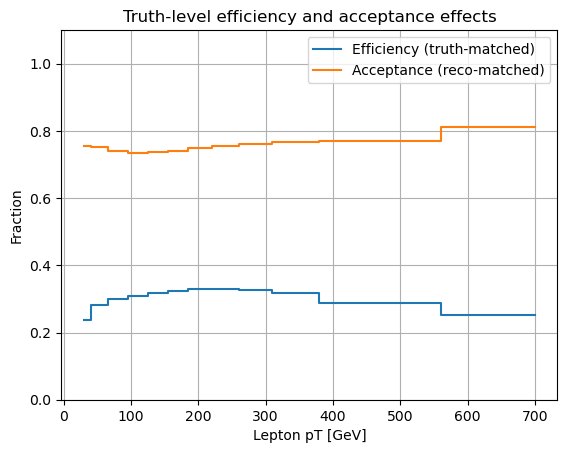

In [52]:
# Efficiency
efficiency = np.zeros_like(unmatched_hist, dtype=float)
efficiency = matched_hist / unmatched_hist

# Acceptance
acceptance = np.zeros_like(reco_matched_hist, dtype=float)
acceptance = reco_matched_hist / reco_unmatched_hist
# Plot efficiency
plt.step(edges[:-1], efficiency, where="mid", label='Efficiency (truth-matched)')
plt.step(edges[:-1], acceptance, where="mid", label='Acceptance (reco-matched)')
plt.xlabel("Lepton pT [GeV]")
plt.ylabel("Fraction")
plt.ylim(0, 1.1)
plt.title("Truth-level efficiency and acceptance effects")
plt.grid(True)
plt.legend()
plt.show()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


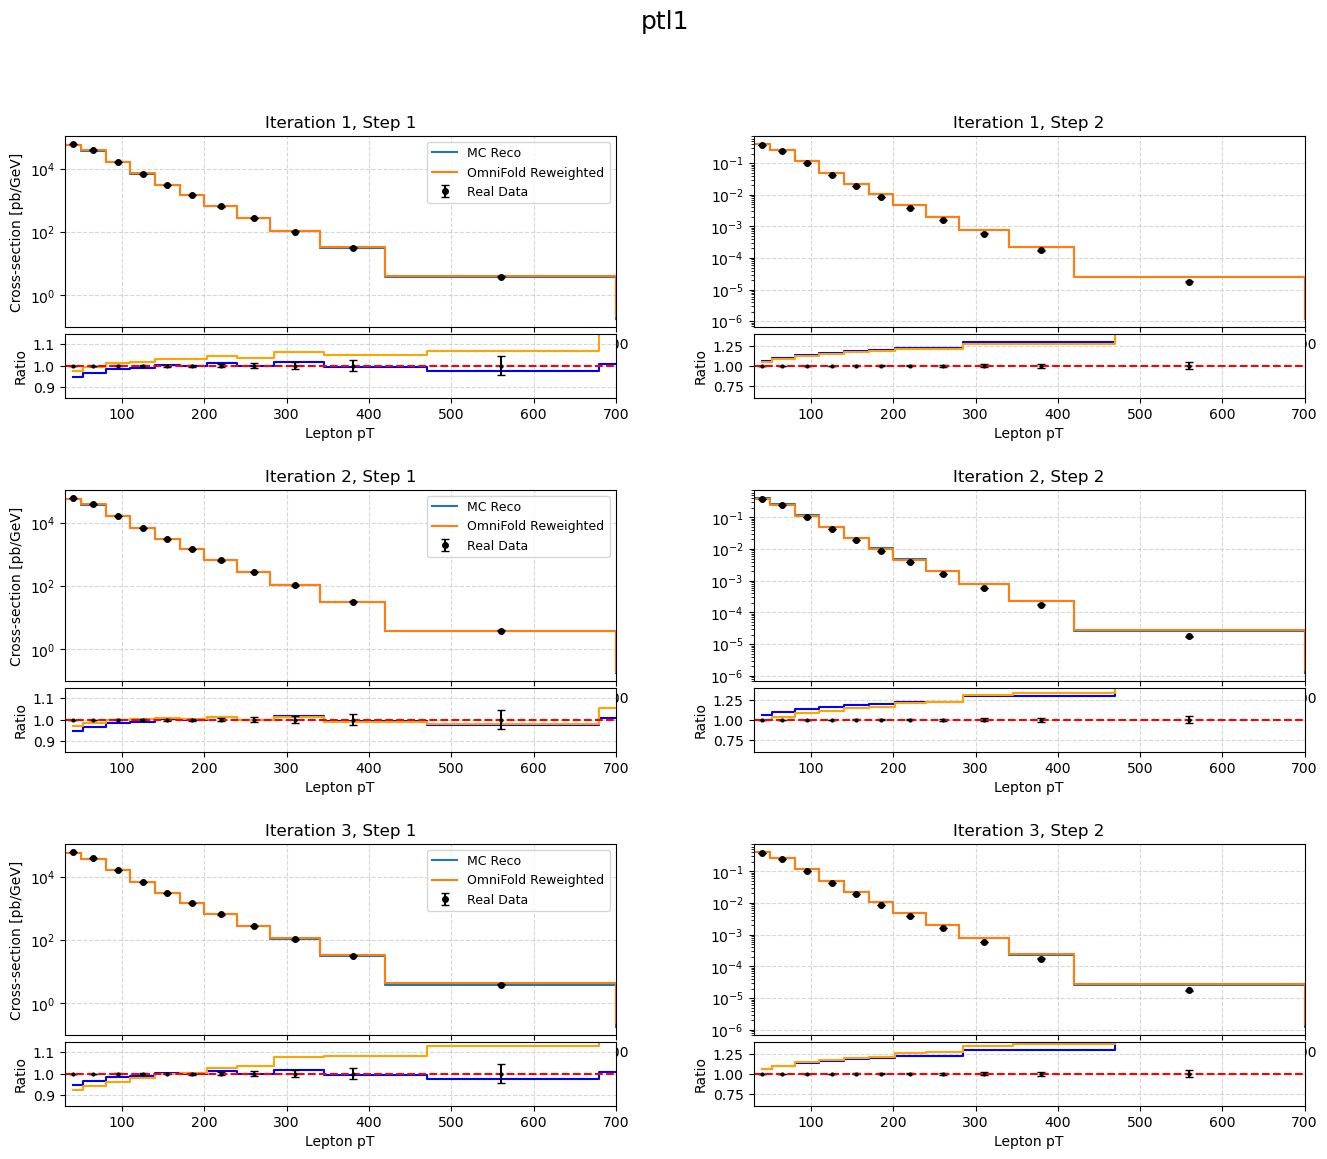

In [ ]:
obs_name = "ptl1"
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
n_iterations = 3

# -----------------------------
# Step 1: Precompute cumulative weights
# -----------------------------
def precompute_realdata_weights(n_iterations):
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1 weights
        w1 = load_updated_weights(it, 1)
        weights_pull = w1 * weights_push

        # Step 2 weights
        w2 = load_updated_weights(it, 2)
        weights_push = w2

        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list

weights_pull_list, weights_push_list = precompute_realdata_weights(n_iterations)

# -----------------------------
# Step 2: Plotting function
# -----------------------------
def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # Particle-level TUnfold histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()  # TUnfold particle-level data

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"] * SF
    )

    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 0, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    acceptance = reco_matched_hist / reco_unmatched_hist

    values = values * efficiency
    values_density = values / bin_widths

    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]
        # MC uncertainty
        sum_w2_mc, _ = np.histogram(
            values_mc, bins=edges, weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
        )
        err_mc = np.sqrt(sum_w2_mc) / bin_widths

        # OmniFold uncertainty
        sum_w2_omnifold, _ = np.histogram(
            values_mc, bins=edges,
            weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
        )
        err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths
        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                data_counts, _ = np.histogram(
                    data_array[:, 0, 0], bins=edges,
                    weights=data_subset["eventWeight"]
                )
                data_counts *= acceptance
                data_density = data_counts / bin_widths

                mc_counts, _ = np.histogram(
                    pythia_reco_test[:, 0, 0], bins=edges,
                    weights=testset_loader.weight
                )
                mc_rew_counts, _ = np.histogram(
                    pythia_reco_test[:, 0, 0], bins=edges,
                    weights=testset_loader.weight * weights_pull
                )

                # Main panel
                ax_main.step(edges[:-1], mc_counts / bin_widths, where='post', label='MC Reco')
                ax_main.step(edges[:-1], mc_rew_counts / bin_widths, where='post', label='OmniFold Reweighted')
                ax_main.errorbar(
                    bin_centers[:-1], data_density[:-1],
                    yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                    fmt='o', color='black', capsize=3, markersize=4,
                    label='Real Data'
                )

                ax_main.set_yscale('log')
                ax_main.set_ylabel("Cross-section [pb/GeV]")
                ax_main.grid(True, ls='--', alpha=0.5)
                ax_main.legend(fontsize=9)
                ax_main.set_xlim(30,700)

                # Ratio panel
                ratio_data = np.ones_like(data_density)
                ratio_mc = mc_counts / data_counts
                ratio_rew = mc_rew_counts / data_counts
                # Ratio for MC / ref
                ratio_mc = counts_mc_density / values_density
                rel_err_mc = err_mc / counts_mc_density
                rel_err_mc[~np.isfinite(rel_err_mc)] = 0  # avoid NaNs

                # Ratio for OmniFold / ref
                ratio_omnifold = counts_omnifold_density / values_density
                rel_err_omnifold = err_omnifold / counts_omnifold_density
                rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

                yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
                ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
                ax_ratio.fill_between(
                    bin_centers,
                    ratio_mc * (1 - rel_err_mc),
                    ratio_mc * (1 + rel_err_mc),
                    step='mid', color='blue', alpha=0.2
                )
                ax_ratio.step(bin_centers, ratio_rew, where='mid', color='orange', label='OmniFold / Data')
                ax_ratio.fill_between(
                    bin_centers,
                    ratio_omnifold * (1 - rel_err_omnifold),
                    ratio_omnifold * (1 + rel_err_omnifold),
                    step='mid', color='orange', alpha=0.2
                )
                ax_ratio.errorbar(bin_centers[:-1], ratio_data[:-1], yerr=yerr_data[:, :-1],
                                  fmt='o', color='black', capsize=3, markersize=2, label='Data stat. unc.')
                ax_ratio.axhline(1.0, color='r', ls='--')
                ax_ratio.set_ylim(0.85, 1.15)
                ax_ratio.grid(True, ls='--', alpha=0.5)
                ax_ratio.set_xlabel("Lepton pT")
                ax_ratio.set_xlim(30,700)
                ax_ratio.set_ylabel("Ratio")
                ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

            else:
                # ---------------- Particle-level ----------------
                counts_mc, _ = np.histogram(
                    pythia_truth_test[:, 0, 0], bins=edges,
                    weights=testset_loader.weight * SF
                )
                counts_omnifold, _ = np.histogram(
                    pythia_truth_test[:, 0, 0], bins=edges,
                    weights=testset_loader.weight * weights_push * SF
                )
                counts_mc_density = counts_mc / bin_widths
                counts_omnifold_density = counts_omnifold / bin_widths

                ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC Generated')
                ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold Reweighted')
                ax_main.errorbar(
                    bin_centers[:-1],
                    values_density[:-1],
                    yerr=np.vstack((rel_pt_down * values_density, rel_pt_up * values_density))[:, :-1],
                    fmt='o', color='black', capsize=3, markersize=4,
                    label='TUnfold Data'
                )
                ax_main.set_yscale('log')
                ax_main.set_xlim(30,700)
                ax_main.grid(True, ls='--', alpha=0.5)
                # Ratio panel
                ratio_tunfold = np.ones_like(values_density)
                ratio_mc = counts_mc_density / values_density
                ratio_omnifold = counts_omnifold_density / values_density

                yerr_tunfold = np.vstack((ratio_tunfold * rel_pt_down, ratio_tunfold * rel_pt_up))
                ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / TUnfold')
                ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / TUnfold')
                ax_ratio.errorbar(bin_centers[:-1], ratio_tunfold[:-1], yerr=yerr_tunfold[:, :-1],
                                  fmt='o', color='black', capsize=3, markersize=2, label='TUnfold stat. unc.')
                ax_ratio.axhline(1.0, color='r', ls='--')
                ax_ratio.set_ylim(0.6, 1.4)
                ax_ratio.grid(True, ls='--', alpha=0.5)
                ax_ratio.set_xlabel("Lepton pT")
                ax_ratio.set_ylabel("Ratio")
                ax_ratio.set_xlim(30,700)
                ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig

# -----------------------------
# Step 3: Run the plot
# -----------------------------
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()


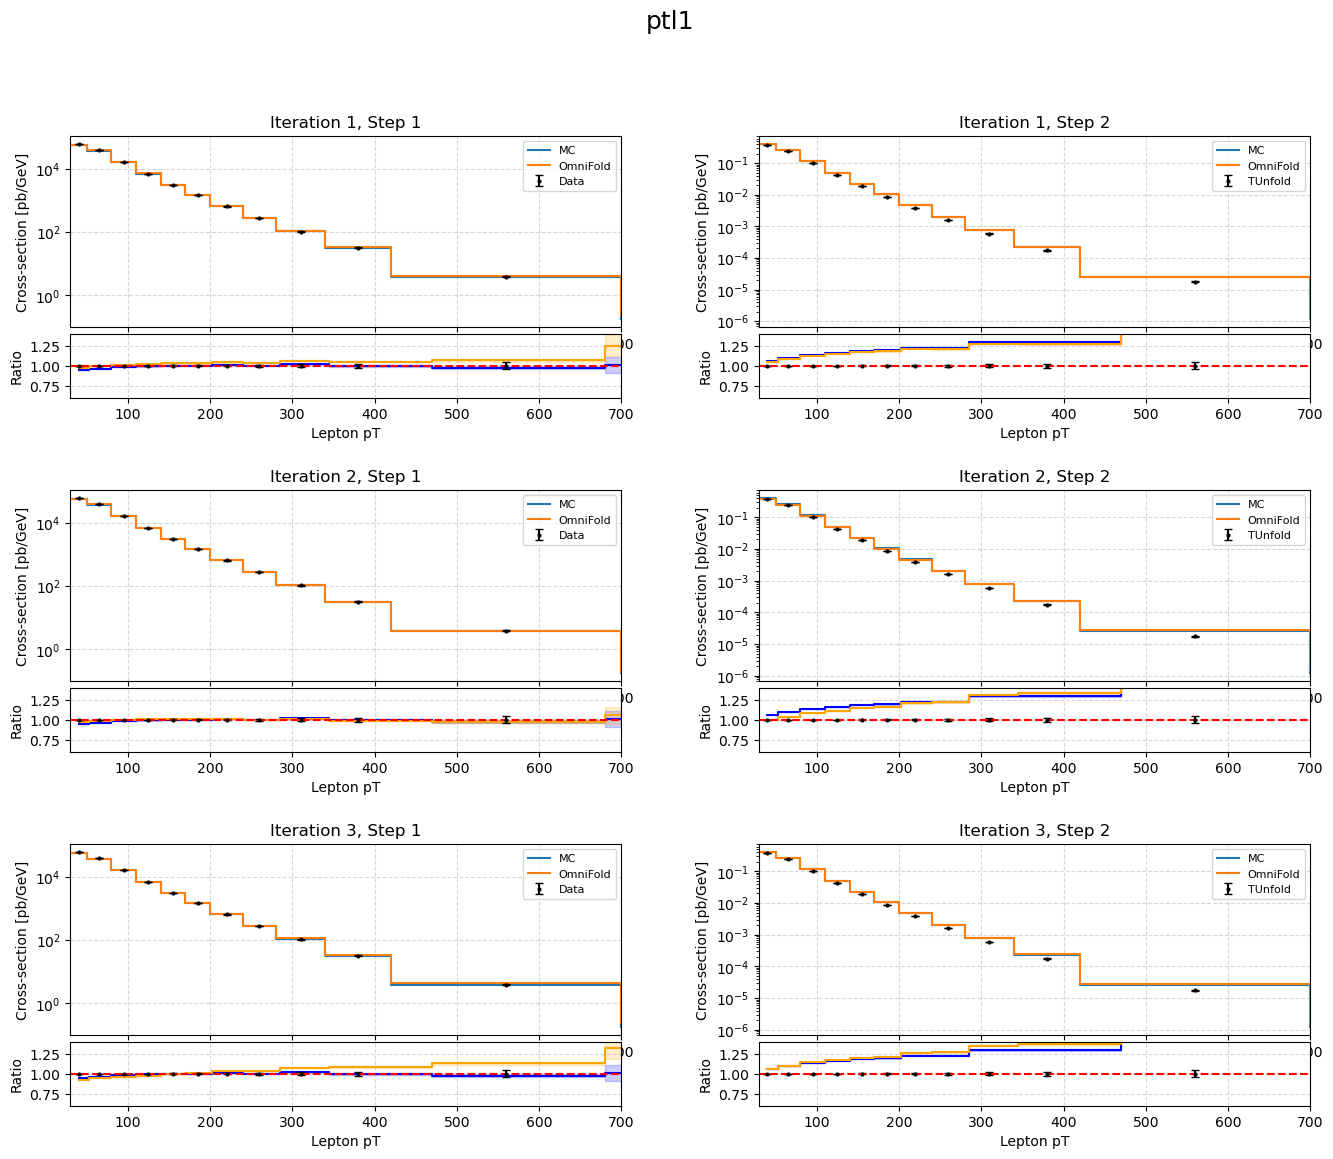

In [86]:
def plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False):
    fig = plt.figure(figsize=(16, 4.2 * n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # TUnfold particle-level histogram
    hist = TUnfold_incl_file[f"unfolding_{obs_name}_NOSYS"]
    edges = hist.axis().edges()
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_widths = np.diff(edges)
    values = hist.values()

    rel_pt_up = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1up;1"].values()
    rel_pt_down = TUnfold_incl_file[f"unfolding_error_{obs_name}_direct_STAT_DATA__1down;1"].values()
    values_density = values / bin_widths

    # ------------------------------------------------------------
    # Efficiency / acceptance (once)
    # ------------------------------------------------------------
    matched_hist, _ = np.histogram(
        pythia_truth_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    unmatched_hist, _ = np.histogram(
        pythia_truth_unmatched[:, 0, 0],
        bins=edges,
        weights=pythia_unmatched["eventWeight"] * SF
    )
    reco_matched_hist, _ = np.histogram(
        pythia_reco_matched[:, 0, 0],
        bins=edges,
        weights=pythia_matched["eventWeight"] * SF
    )
    reco_unmatched_hist, _ = np.histogram(
        pythia_reco_unmatched[:, 0, 0][pythia_reco_unmatched[:, 0, 0] != 0],
        bins=edges,
        weights=(pythia_unmatched["eventWeight"] * SF)[
            pythia_reco_unmatched[:, 0, 0] != 0
        ]
    )

    efficiency = matched_hist / unmatched_hist
    acceptance = reco_matched_hist / reco_unmatched_hist
    values_density *= efficiency

    # ------------------------------------------------------------
    # Loop over iterations
    # ------------------------------------------------------------
    for it in range(n_iterations):
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        for stepn in [1, 2]:
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn == 1:
                # ---------------- Detector-level ----------------
                values_mc = pythia_reco_test[:, 0, 0]
                unfolded_weights = weights_pull
                data_counts, _ = np.histogram(
                    data_array[:, 0, 0], bins=edges,
                    weights=data_subset["eventWeight"]
                )
                data_counts *= acceptance
                data_density = data_counts / bin_widths

            else:
                # ---------------- Particle-level ----------------
                values_mc = pythia_truth_test[:, 0, 0]
                unfolded_weights = weights_push
                data_density = values_density

            # ----------------------------------------------------
            # MC histogram and uncertainty
            # ----------------------------------------------------
            counts_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=testset_loader.weight if stepn==1 else testset_loader.weight*SF
            )
            counts_mc_density = counts_mc / bin_widths
            sum_w2_mc, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight if stepn==1 else testset_loader.weight*SF)**2
            )
            err_mc = np.sqrt(sum_w2_mc) / bin_widths

            # ----------------------------------------------------
            # OmniFold histogram and uncertainty
            # ----------------------------------------------------
            counts_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)
            )
            counts_omnifold_density = counts_omnifold / bin_widths
            sum_w2_omnifold, _ = np.histogram(
                values_mc, bins=edges,
                weights=(testset_loader.weight*unfolded_weights if stepn==1 else testset_loader.weight*weights_push*SF)**2
            )
            err_omnifold = np.sqrt(sum_w2_omnifold) / bin_widths

            # ----------------------------------------------------
            # Main panel
            # ----------------------------------------------------
            ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
            ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold')
            ax_main.errorbar(
                bin_centers[:-1],
                data_density[:-1],
                yerr=np.vstack((rel_pt_down * data_density, rel_pt_up * data_density))[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data' if stepn==1 else 'TUnfold'
            )
            ax_main.set_yscale('log')
            ax_main.set_ylabel("Cross-section [pb/GeV]")
            ax_main.grid(True, ls='--', alpha=0.5)
            ax_main.set_xlim(30, 700)
            ax_main.legend(fontsize=8)

            # ----------------------------------------------------
            # Ratio panel
            # ----------------------------------------------------
            ratio_data = np.ones_like(data_density)
            ratio_mc = counts_mc_density / data_density
            ratio_omnifold = counts_omnifold_density / data_density

            rel_err_mc = err_mc / counts_mc_density
            rel_err_mc[~np.isfinite(rel_err_mc)] = 0
            rel_err_omnifold = err_omnifold / counts_omnifold_density
            rel_err_omnifold[~np.isfinite(rel_err_omnifold)] = 0

            # Blue: MC
            ax_ratio.step(bin_centers, ratio_mc, where='mid', color='blue', label='MC / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_mc * (1 - rel_err_mc),
                ratio_mc * (1 + rel_err_mc),
                step='mid', color='blue', alpha=0.2
            )

            # Orange: OmniFold
            ax_ratio.step(bin_centers, ratio_omnifold, where='mid', color='orange', label='OmniFold / Data')
            ax_ratio.fill_between(
                bin_centers,
                ratio_omnifold * (1 - rel_err_omnifold),
                ratio_omnifold * (1 + rel_err_omnifold),
                step='mid', color='orange', alpha=0.2
            )

            # Black points at 1
            yerr_data = np.vstack((ratio_data * rel_pt_down, ratio_data * rel_pt_up))
            ax_ratio.errorbar(
                bin_centers[:-1], ratio_data[:-1],
                yerr=yerr_data[:, :-1],
                fmt='o', color='black', capsize=3, markersize=2,
                label='Data stat. unc.'
            )

            ax_ratio.axhline(1.0, color='r', ls='--')
            ax_ratio.set_ylim(0.6, 1.4)
            ax_ratio.set_xlabel("Lepton pT")
            ax_ratio.set_ylabel("Ratio")
            ax_ratio.grid(True, ls='--', alpha=0.5)
            ax_main.set_title(f"Iteration {it + 1}, Step {stepn}")

    fig.suptitle(f"{obs_name}", fontsize=18)
    return fig
fig = plot_all_iterations_realdata_unified(obs_name, n_iterations, weights_pull_list, weights_push_list, logx=False)
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = 1 / luminosity

observables = {
    "ptl1": 0,
    "ptb1": 1,
    "ptb2": 2,
    "met": 11,
}

def load_unfolded_weights(iteration, stepn, ensemble=0):
    """
    Load the OmniFold weights for a given iteration and step.
    """
    model_name = f"{weight_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}.weights.h5"

    if not os.path.exists(model_name):
        raise FileNotFoundError(f"{model_name} does not exist")

    if stepn == 1:
        my_model = omnifold.model1
        in_data = Y_reco_scaled
    else:
        my_model = omnifold.model2
        in_data = Y_truth_scaled

    my_model.build(input_shape=(None, in_data.shape[1], in_data.shape[2]))
    my_model.load_weights(model_name)

    f = omnifold_routine.expit(my_model.predict(in_data, batch_size=1000))
    w = f / (1 - f)
    w = np.nan_to_num(w[:, 0], posinf=1)
    return w

# ------------------------ MULTIPAGE PDF ------------------------
pdf_filename = os.path.join(weight_folder, f"{omnifold_name}_comparison_TUnfold.pdf")
with PdfPages(pdf_filename) as pdf:

    for iteration in range(5):
        # Load weights for current iteration
        unfolded_weights_step1 = load_unfolded_weights(iteration, stepn=1)
        unfolded_weights_step2 = load_unfolded_weights(iteration, stepn=2)

        fig = plt.figure(figsize=(14, 16))
        outer_gs = fig.add_gridspec(4, 2, wspace=0.3, hspace=0.35)
        fig.text(0.25, 0.9, "Detector-Level", ha='center', fontsize=14, fontweight='bold')
        fig.text(0.75, 0.9, "Particle-Level", ha='center', fontsize=14, fontweight='bold')


        for row_idx, (obs_name, obs_index) in enumerate(observables.items()):
            # TUnfold bins and values
            hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
            edges = hist.axis().edges()
            bin_widths = np.diff(edges)
            bin_centers = 0.5 * (edges[:-1] + edges[1:])
            values_tunfold = hist.values()
            values_density = values_tunfold / bin_widths

            rel_pt_up = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1up;1']
            rel_pt_down = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1down;1']
            rel_unc_up_tunfold = rel_pt_up.values()
            rel_unc_down_tunfold = rel_pt_down.values()

            yerr = np.vstack((rel_unc_down_tunfold * values_density,
                              rel_unc_up_tunfold * values_density))

            for stepn in [1, 2]:
                col_idx = stepn - 1
                inner_gs = outer_gs[row_idx, col_idx].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
                ax_main = fig.add_subplot(inner_gs[0])
                ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)

                if stepn == 1:
                    values_data = data_array[:, obs_index, 0]
                    values_mc = pythia_reco_test[:, obs_index, 0]
                    weights_omnifold = unfolded_weights_step1 * pythia_test['eventWeight'] * SF
                    counts_data, _ = np.histogram(values_data, bins=edges, weights=data_subset['eventWeight']*SF)
                    counts_data_density = counts_data / bin_widths
                    data_label = "Run-II Data"
                else:
                    values_data = values_tunfold
                    values_mc = pythia_truth_test[:, obs_index, 0]
                    weights_omnifold = unfolded_weights_step2 * pythia_test['eventWeight'] * SF
                    data_label = "TUnfold"

                # OmniFold histograms and uncertainties
                counts_omnifold, _ = np.histogram(values_mc, bins=edges, weights=weights_omnifold)
                counts_omnifold2, _ = np.histogram(values_mc, bins=edges, weights=weights_omnifold**2)
                rel_unc_omnifold = np.zeros_like(counts_omnifold)
                mask = counts_omnifold > 0
                rel_unc_omnifold[mask] = np.sqrt(counts_omnifold2[mask]) / counts_omnifold[mask]
                counts_omnifold_density = counts_omnifold / bin_widths

                # MC reference histogram
                counts_mc, _ = np.histogram(values_mc, bins=edges, weights=pythia_test['eventWeight']*SF)
                counts_mc_density = counts_mc / bin_widths

                # ---------------- Main panel ----------------
                ax_main.errorbar(
                    bin_centers[:-1], counts_data_density[:-1],
                    yerr=yerr[:, :-1], fmt='o', color='black', capsize=3, markersize=4,
                    label=data_label
                )
                ax_main.step(edges[:-1], counts_mc_density, where='post', label='MC')
                ax_main.step(edges[:-1], counts_omnifold_density, where='post', label='OmniFold')
                ax_main.fill_between(
                    edges[:-1],
                    counts_omnifold_density*(1-rel_unc_omnifold),
                    counts_omnifold_density*(1+rel_unc_omnifold),
                    step='post', color='orange', alpha=0.2, label='OmniFold stat. unc.'
                )
                ax_main.set_ylabel("Cross-section [pb/GeV]")
                ax_main.set_yscale('log')
                ax_main.grid(True, linestyle='--', alpha=0.5)
                ax_main.legend(fontsize=8)

                # ---------------- Ratio panel ----------------
                ratio_mc = np.divide(counts_mc_density, counts_data_density, out=np.zeros_like(counts_mc_density), where=counts_data_density != 0)
                ratio_omnifold = np.divide(counts_omnifold_density, counts_data_density, out=np.zeros_like(counts_omnifold_density), where=counts_data_density != 0)

                ax_ratio.step(edges[:-1], ratio_mc, where='post', color="blue", label="MC / TUnfold")
                ax_ratio.step(edges[:-1], ratio_omnifold, where='post', color="orange", label="OmniFold / TUnfold")
                ax_ratio.fill_between(
                    edges[:-1],
                    ratio_omnifold*(1-rel_unc_omnifold),
                    ratio_omnifold*(1+rel_unc_omnifold),
                    step='post', color='orange', alpha=0.2, label='OmniFold stat. unc.'
                )
                ax_ratio.errorbar(
                    bin_centers[:-1], np.ones_like(bin_centers[:-1]),
                    yerr=yerr[:, :-1], fmt='o', color='black', capsize=3, label=data_label
                )
                ax_ratio.set_xlabel(obs_name)
                ax_ratio.set_ylabel("Ratio")
                ax_ratio.set_ylim(0.6, 1.4)
                ax_ratio.grid(True, linestyle='--', alpha=0.5)

        fig.suptitle(f"Comparison of TUnfold and OmniFold (Iteration {iteration})", fontsize=16)
        #plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved multipage PDF: {pdf_filename}")


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


/tmp/ipykernel_2234420/2641630069.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Saved multipage PDF: /scratch/mjosef/Unfolding/omnifold/weights_pythia_WWbbvsDATA/pythiaWWbb_vs_real-data-5_iter-2M_evts_12_comparison_TUnfold.pdf
